In [1]:
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from sys import path
from os.path import exists
from imp import reload
from netCDF4 import Dataset
# path.insert(0, '/Users/H/WAVES/geo_data_group/')
path.insert(0, '/Users/owylie/MSci/')
import grid_set as gs

### CLASSES

In [2]:
#### for ice drift
### find it here:
### https://nsidc.org/data/NSIDC-0116/versions/4
### one file per year, put them all in one folder
class Pathfinder():
    """
    forcing class for the budget
    lets the forcing load efficiently
    
    """
    def __init__(self,ppath,grid=False):
        self.name = 'Pathfinder'
        self.path = ppath
        self.vyear_load = 0
        self.vels_loaded = False
        if type(grid) == bool:
            self.check_grid = False
        else:
            self.check_grid = True
            self.grid = grid
        
    def get_dates(self,time_start,time_end):
        """
        returns the all encompassing date list for use with the forcing object
        """
        dates =[]
        d0 = dt.datetime(1970,1,1)
        n_yrs = (time_end.year - time_start.year)+1
        for y in range(n_yrs):
            yu = time_start.year + y
            f_name = 'icemotion_daily_nh_25km_'+str(yu)+'0101_'+str(yu)+'1231_v4.1.nc'
            if exists(self.path+f_name):
                ### converting days_since_1970-01-01 to datetimes
                f_nc = Dataset(self.path+f_name)
                [dates.append(d0 + relativedelta(days = d))
                     for d in f_nc['time'][:]]
                f_nc.close()
        self.dates = dates
        print(self.name+' Found '+str(np.shape(dates)[0])+' dates')


    # next function will take a list of dates and return an appropriately orientated arrays
    # give a 
    def get_vels(self,dates_u,verbos=False):
        d0 = dt.datetime(1970,1,1)
        # does dates_u cover one year or more
        if (dates_u[-1].year -dates_u[0].year) == 0:
            # one year, one file
            yu = dates_u[0].year
            if ((self.vyear_load != yu) or (not self.vels_loaded)):
                print('loading new year of data: '+str(yu))
                f_name = 'icemotion_daily_nh_25km_'+str(yu)+'0101_'+str(yu)+'1231_v4.1.nc'
                f_nc = Dataset(self.path+f_name)
        #         print(p0,p1)
                self.u = f_nc['u'][:]
                self.v = f_nc['v'][:]
                self.u[self.u.mask] = np.nan
                self.v[self.v.mask] = np.nan
                f_nc.close()
                self.vyear_load = yu
                self.vels_loaded= True
            p0 = dates_u[ 0].timetuple().tm_yday -1
            p1 = dates_u[-1].timetuple().tm_yday 
            datau = self.u[p0:p1,:,:].transpose((0,2,1))/100
            datav = self.v[p0:p1,:,:].transpose((0,2,1))/100
            if self.check_grid:
                for n in range(np.shape(datau)[0]):
                    datau[n][self.grid.lats>88] = np.nanmean
                    datav[n][self.grid.lats>88] = np.nanmean
            return datau,datav


In [3]:
#ERA5 10m MONTHLY winds
class ERA5_months():
    """
    forcing class for the budget
    lets the forcing load efficiently
   
    """
    def __init__(self,ppath):
        self.name = 'ERA5_Monthly_Winds'
        self.path = ppath
        self.file = self.path+'monthly_2011-21.nc' 
        self.f_nc = Dataset(self.file)
       
    def get_dates(self,month_wanted):
        """
        returns the all encompassing date list for use with the forcing object
        """
        d0 = dt.datetime(2011,1,1) #first month of dataset
        self.file = self.path+'monthly_2011-21.nc' 
        self.f_nc = Dataset(self.file)
        self.months = self.f_nc.variables['time'][:]
        #this makes sure we have the month that is asked for:
        self.months_all = [d0 + relativedelta(months=m) for m in range(len(self.months))]
        self.times = [d for d in self.months_all if d >= month_wanted and d < month_wanted+relativedelta(months=1)] 
        #print(self.name+' Found '+str(np.shape(self.times)[0])+' data points')
        
        
    def get_vels(self):
        """
        NOTE: gives the velocities of the month specified in get_dates above, NOT in get_vels as usual
        """
        #finding the index:
        n = 0
        for n in range(0,len(self.months)):
            if self.months_all[n] in self.times:
                idx = n

        u10 = self.f_nc.variables['u10'][idx]
        v10 = self.f_nc.variables['v10'][idx]
        
        return u10,v10

In [4]:
class NSIDC_nt():
    """
    forcing class for the budget
    lets the forcing load efficiently
    
    """
    def __init__(self,ppath):
        self.name = 'NSIDC_n'
        self.path = ppath
# next function will take a list of dates and return an appropriately orientated arrays
# give a 
    def get_aice(self,dates_u,verbos=False):
        # does dates_u cover one year or more
        #daily files
        dimY = 304
        dimX = 448
        d_no = np.shape(dates_u)[0]
        data =  np.empty([d_no, dimX, dimY])
        for n,d in enumerate(dates_u):
            #if d>=dt.datetime(2020,11,1):
                #infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f18_nrt_n.bin"
            #else:
            infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f17_v1.1_n.bin"
            with open(infile, 'rb') as fr:
                hdr = fr.read(300)
                ice = np.fromfile(fr, dtype=np.uint8)

            ice = ice.reshape(dimX,dimY)
            ice = np.flipud(ice)
            data[n] = ice / 250.
        data[data>1.0] = np.nan
        return data

    def get_dates(self,time_start,time_end):
        # does dates_u cover one year or more
        #daily files
        dates_u = []
        d_no = (time_end-time_start).days +3 
        # make sure we get the bracket points
        for dn in range(d_no):
            d = time_start+ relativedelta(days = dn - 1)
            #if d>=dt.datetime(2020,11,1):
            #    infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f18_nrt_n.bin"
            #else:
#             if d.year>2019:
            infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f17_v1.1_n.bin"
            # check infile exists 
            if exists(infile):
                dates_u.append(d)
            #if it does append dates_u
        self.dates= dates_u
        print(self.name+' Found '+str(np.shape(dates_u)[0])+' dates')


In [5]:
#### for geostropic vels
### find it here:
### http://www.cpom.ucl.ac.uk/dynamic_topography/
### one file for all of it
class CPOM_geo():
    """
    forcing class for the budget
    lets the forcing load efficiently
    """
    def __init__(self,ppath,grid=False):
        self.name = 'CPOM_Geostrophic_Currents'
        d0 = dt.datetime(2000,1,1)
        self.path = ppath
        self.file = self.path+'Full_DOT_data_Arco.nc'
        self.f_nc = Dataset(self.file)
        self.time_vec = self.f_nc.variables['time'][:]
        self.dates_all = [d0+relativedelta(days=t) for t in self.time_vec]
        
    def get_dates(self,time_start,time_end):
        """
        returns the all encompassing date list for use with the forcing object
        """
        d0 = dt.datetime(2000,1,1)
        self.file = self.path+'Full_DOT_data_Arco.nc'
        self.f_nc = Dataset(self.file)
        self.time_vec = self.f_nc.variables['time'][:]
        self.dates_all = [d0+relativedelta(days=t) for t in self.time_vec]
        self.dates = [ d for d in self.dates_all if d >= time_start and d <= time_end]
        print(self.name+' Found '+str(np.shape(self.dates)[0])+' dates')

    # next function will take a list of dates and return an appropriately orientated arrays
    # give a 
    def get_vels(self,dates_u,verbos=False):
        d0 = dt.datetime(2000,1,1)
        ### find the indices
        idx = [np.argwhere(np.array([d == du for d  in self.dates_all] ))[0,0] 
                                             for du in dates_u]
        ### little bit of checking
        if verbos:
            for i,du in zip(idx,dates_u):
                dcheck = dt.datetime(1,1,1)
                dcheck = dcheck+relativedelta(days=self.time_vec[i])
                dcheck = dcheck+relativedelta(years=-1)
                print(du.strftime('%Y%m%d-')+dcheck.strftime('%Y%m%d'))
        datau =  self.f_nc.variables['Geo_surf_current_x'][idx]
        datav = -self.f_nc.variables['Geo_surf_current_y'][idx]
        return datau,datav


### GRIDS

In [6]:
### GPLOT SET UP

m = ccrs.NorthPolarStereo()

#### setup plotting grid - Gplot
f = plt.figure()
Gplot= gs.grid_set(m)

ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
### make a new grid
Gplot.set_grid_mn(30,30,ax)
Gplot.get_grid_info(av_ang=False)
plt.close()

Got a grid res =  30  x  30
Grid distances calculated:  188686.82035191165  x  188898.93509145544
Angles calculated


In [7]:
#opening files, getting native grids

#ice drift
DRIFT = Pathfinder('/Users/owylie/MSci/Pathfinder/')

GPathfinder = gs.grid_set(m)
GPathfinder.load_grid('/Users/owylie/MSci/Pathfinder_gs.npz')
GPathfinder2Gplot = gs.Gs2Gs(GPathfinder,Gplot,vectors=True)


#ice concentration
IConc = NSIDC_nt('/Users/owylie/MSci/NSIDC_nt')

GIC = gs.grid_set(m)
GIC.load_grid('/Users/owylie/MSci/NSIDC_gs.npz')
GIC2GPathfinder = gs.Gs2Gs(GIC,GPathfinder,vectors=False)


#geo currents
GEO = CPOM_geo('/Users/owylie/MSci/CPOM_geo/')

GCPOM = gs.grid_set(m)
GCPOM.load_grid('/Users/owylie/MSci/PS_20km_gs2021.npz')
GCPOM2GPathfinder = gs.Gs2Gs(GCPOM,GPathfinder,vectors=True)


#winds
MWinds = ERA5_months('/Users/owylie/MSci/ERA5/')

lonE = MWinds.f_nc.variables['longitude'][:].data
latE = MWinds.f_nc.variables['latitude'][:].data
lon,lat = np.meshgrid(lonE,latE)
lon[lat<60] = np.nan
lat[lat<60] = np.nan
GEmonth = gs.grid_set(m)
GEmonth.set_grid_lon_lat(lon,lat)
GEmonth.blank_grid_info()
GEmonth.ang_c[:] = 1.0
GEmonth2GPathfinder = gs.Gs2Gs(GEmonth,GPathfinder,vectors=True,NaN_avoid=True)

Loaded a grid: /Users/owylie/MSci/Pathfinder_gs.npz
Loaded a grid: /Users/owylie/MSci/NSIDC_gs.npz
Loaded a grid: /Users/owylie/MSci/PS_20km_gs2021.npz
Got a grid res =  161  x  1440
Note that all grid info is in nx x ny grids, whilst data is in nx x ny
Gs2Gs bad point avoidance found  57600


### MONTHLY AVERAGES

In [8]:
import Ice_Conc as IC
import Ice_Drift as ID
import Ekman_pumping as ep
import Calculating_pumping as CP

m_use = ep.m_AIDJEX_0
[Ca,Co] = m_use[0:2] #this just gets the values of Ca and Co, can change to regular values if you want

MLD=20.0 #Ekman depth 
omega= 2.*np.pi/24./60./60. #Earths rotation
fcor = 2.*omega*np.sin(np.deg2rad(GPathfinder.lats.T)) #coriolis force

Loaded a grid: /Users/owylie/MSci/NSIDC_gs.npz
Loaded a grid: /Users/owylie/MSci/Pathfinder_gs.npz
Got a grid res =  30  x  30
Grid distances calculated:  188686.82035191165  x  188898.93509145544
Angles calculated
Loaded a grid: /Users/owylie/MSci/Pathfinder_gs.npz
Loaded a grid: /Users/owylie/MSci/Pathfinder_gs.npz


#### JANUARY

In [9]:
#ice drift
id_jan10_u, id_jan10_v, id_jan10_ur, id_jan10_vr = ID.ID_av.jan(2010)
id_jan11_u, id_jan11_v, id_jan11_ur, id_jan11_vr = ID.ID_av.jan(2011)
id_jan12_u, id_jan12_v, id_jan12_ur, id_jan12_vr = ID.ID_av.jan(2012)
id_jan13_u, id_jan13_v, id_jan13_ur, id_jan13_vr = ID.ID_av.jan(2013)
id_jan14_u, id_jan14_v, id_jan14_ur, id_jan14_vr = ID.ID_av.jan(2014)
id_jan15_u, id_jan15_v, id_jan15_ur, id_jan15_vr = ID.ID_av.jan(2015)
id_jan16_u, id_jan16_v, id_jan16_ur, id_jan16_vr = ID.ID_av.jan(2016)
id_jan17_u, id_jan17_v, id_jan17_ur, id_jan17_vr = ID.ID_av.jan(2017)
id_jan18_u, id_jan18_v, id_jan18_ur, id_jan18_vr = ID.ID_av.jan(2018)
id_jan19_u, id_jan19_v, id_jan19_ur, id_jan19_vr = ID.ID_av.jan(2019)
id_jan20_u, id_jan20_v, id_jan20_ur, id_jan20_vr = ID.ID_av.jan(2020)

#ice concentration
ic_jan10, ic_jan10r = IC.IC_av.jan(2010)
ic_jan11, ic_jan11r = IC.IC_av.jan(2011)
ic_jan12, ic_jan12r = IC.IC_av.jan(2012)
ic_jan13, ic_jan13r = IC.IC_av.jan(2013)
ic_jan14, ic_jan14r = IC.IC_av.jan(2014)
ic_jan15, ic_jan15r = IC.IC_av.jan(2015)
ic_jan16, ic_jan16r = IC.IC_av.jan(2016)
ic_jan17, ic_jan17r = IC.IC_av.jan(2017)
ic_jan18, ic_jan18r = IC.IC_av.jan(2018)
ic_jan19, ic_jan19r = IC.IC_av.jan(2019)
ic_jan20, ic_jan20r = IC.IC_av.jan(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,1,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,1,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,1,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,1,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,1,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,1,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,1,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,1,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,1,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,1,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,1,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,1,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,1,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,1,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,1,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,1,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,1,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,1,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,1,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,1,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,1,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:224: RuntimeWarning: Mean of empty slice
  jan_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,u16,u17,u18,u19,u20,
/Users/owylie/MSci/Ice_Drift.py:226: RuntimeWarning: Mean of empty slice
  jan_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,
/Users/owylie/MSci/Ice_Drift.py:228: RuntimeWarning: Mean of empty slice
  jan_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:230: RuntimeWarning: Mean of empty slice
  jan_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:198: RuntimeWarning: Mean of empty slice
  jan = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:200: RuntimeWarning: Mean of empty slice
  jan_r = np.nanmean( np.array([ar1,ar2,ar3,ar

20110101-00110102
20120101-00120101
20130101-00130102
20140101-00140102
20150101-00150102
20160101-00160101
20170101-00170102
20180101-00180102
20190101-00190102
20200101-00200101


In [10]:
#whole time averages:
uwp = np.nanmean(np.array([uwr11,uwr12,uwr13,uwr14,uwr15,uwr16,uwr17,uwr18,uwr19,uwr20]), axis = 0)
vwp = np.nanmean(np.array([vwr11,vwr12,vwr13,vwr14,vwr15,vwr16,vwr17,vwr18,vwr19,vwr20]), axis = 0)

ugp = np.nanmean(np.array([ugr11,ugr12,ugr13,ugr14,ugr15,ugr16,ugr17,ugr18,ugr19,ugr20]), axis = 0)
vgp = np.nanmean(np.array([vgr11,vgr12,vgr13,vgr14,vgr15,vgr16,vgr17,vgr18,vgr19,vgr20]), axis = 0)

alpha = np.nanmean(np.array([ic_jan10r,ic_jan11r,ic_jan12r,ic_jan13r,ic_jan14r,ic_jan15r,ic_jan16r,ic_jan17r,
                           ic_jan18r,ic_jan19r,ic_jan20r]), axis = 0)

upp = np.nanmean(np.array([id_jan10_u,id_jan11_u,id_jan12_u,id_jan13_u,id_jan14_u,id_jan15_u,
                           id_jan16_u,id_jan17_u,id_jan18_u,id_jan19_u,id_jan20_u]), axis=0 )
vpp = np.nanmean(np.array([id_jan10_v,id_jan11_v,id_jan12_v,id_jan13_v,id_jan14_v,id_jan15_v,
                           id_jan16_v,id_jan17_v,id_jan18_v,id_jan19_v,id_jan20_v]), axis=0 )

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/477076461.py:2: RuntimeWarning: Mean of empty slice
  uwp = np.nanmean(np.array([uwr11,uwr12,uwr13,uwr14,uwr15,uwr16,uwr17,uwr18,uwr19,uwr20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/477076461.py:3: RuntimeWarning: Mean of empty slice
  vwp = np.nanmean(np.array([vwr11,vwr12,vwr13,vwr14,vwr15,vwr16,vwr17,vwr18,vwr19,vwr20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/477076461.py:5: RuntimeWarning: Mean of empty slice
  ugp = np.nanmean(np.array([ugr11,ugr12,ugr13,ugr14,ugr15,ugr16,ugr17,ugr18,ugr19,ugr20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/477076461.py:6: RuntimeWarning: Mean of empty slice
  vgp = np.nanmean(np.array([vgr11,vgr12,vgr13,vgr14,vgr15,vgr16,vgr17,vgr18,vgr19,vgr20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/477076461.py:8: RuntimeWarning: Mean of empty slice
  alpha

In [11]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_jan11_u[0],id_jan11_v[0],ugr11,vgr11,ic_jan11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_jan11_u[0],id_jan11_v[0],ugr11,vgr11,ic_jan11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_jan12_u[0],id_jan12_v[0],ugr12,vgr12,ic_jan12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_jan12_u[0],id_jan12_v[0],ugr12,vgr12,ic_jan12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_jan13_u[0],id_jan13_v[0],ugr13,vgr13,ic_jan13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_jan13_u[0],id_jan13_v[0],ugr13,vgr13,ic_jan13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_jan14_u[0],id_jan14_v[0],ugr14,vgr14,ic_jan14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_jan14_u[0],id_jan14_v[0],ugr14,vgr14,ic_jan14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_jan15_u[0],id_jan15_v[0],ugr15,vgr15,ic_jan15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_jan15_u[0],id_jan15_v[0],ugr15,vgr15,ic_jan15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_jan16_u[0],id_jan16_v[0],ugr16,vgr16,ic_jan16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_jan16_u[0],id_jan16_v[0],ugr16,vgr16,ic_jan16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_jan17_u[0],id_jan17_v[0],ugr17,vgr17,ic_jan17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_jan17_u[0],id_jan17_v[0],ugr17,vgr17,ic_jan17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_jan18_u[0],id_jan18_v[0],ugr18,vgr18,ic_jan18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_jan18_u[0],id_jan18_v[0],ugr18,vgr18,ic_jan18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_jan19_u[0],id_jan19_v[0],ugr19,vgr19,ic_jan19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_jan19_u[0],id_jan19_v[0],ugr19,vgr19,ic_jan19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_jan20_u[0],id_jan20_v[0],ugr20,vgr20,ic_jan20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_jan20_u[0],id_jan20_v[0],ugr20,vgr20,ic_jan20r)

In [12]:
ekj = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]),axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1617558652.py:1: RuntimeWarning: Mean of empty slice
  ekj = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]),axis = 0)


In [13]:
ur, vr = GPathfinder2Gplot.rg_vecs(ekj[:,:,0],ekj[:,:,1])

Text(0.5, 1.0, 'Average January 2011-2020')

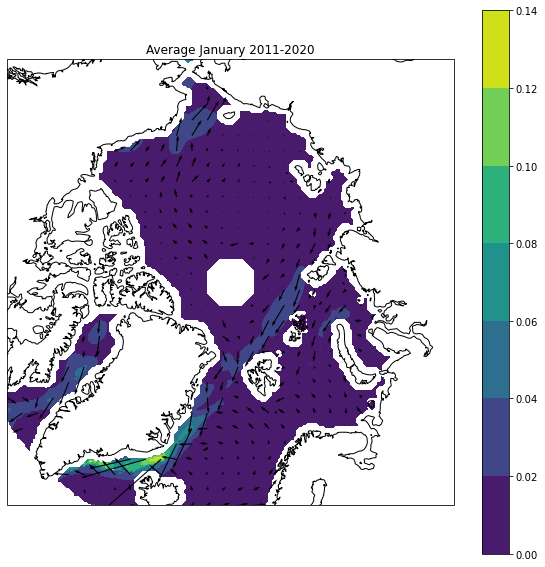

In [14]:
f = plt.figure(figsize=(10,10))

ax = plt.subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ekj[:,:,0],ekj[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ur,vr) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("Average January 2011-2020")

In [15]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_jan11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_jan11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_jan12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_jan12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_jan13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_jan13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_jan14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_jan14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_jan15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_jan15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_jan16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_jan16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_jan17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_jan17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_jan18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_jan18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_jan19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_jan19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_jan20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_jan20 = CP.weighted_pump(tau_20)

In [16]:
#averaging the years
ek_jan = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_jan = np.nanmean(np.array([pump_jan11,pump_jan12,pump_jan13,pump_jan14,pump_jan15,pump_jan16,
                             pump_jan17,pump_jan18,pump_jan19,pump_jan20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4144816120.py:2: RuntimeWarning: Mean of empty slice
  ek_jan = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4144816120.py:3: RuntimeWarning: Mean of empty slice
  pump_jan = np.nanmean(np.array([pump_jan11,pump_jan12,pump_jan13,pump_jan14,pump_jan15,pump_jan16,


#### FEBUARY

In [17]:
#ice drift
id_feb10_u, id_feb10_v, id_feb10_ur, id_feb10_vr = ID.ID_av.feb(2010)
id_feb11_u, id_feb11_v, id_feb11_ur, id_feb11_vr = ID.ID_av.feb(2011)
id_feb12_u, id_feb12_v, id_feb12_ur, id_feb12_vr = ID.ID_av.feb(2012)
id_feb13_u, id_feb13_v, id_feb13_ur, id_feb13_vr = ID.ID_av.feb(2013)
id_feb14_u, id_feb14_v, id_feb14_ur, id_feb14_vr = ID.ID_av.feb(2014)
id_feb15_u, id_feb15_v, id_feb15_ur, id_feb15_vr = ID.ID_av.feb(2015)
id_feb16_u, id_feb16_v, id_feb16_ur, id_feb16_vr = ID.ID_av.feb(2016)
id_feb17_u, id_feb17_v, id_feb17_ur, id_feb17_vr = ID.ID_av.feb(2017)
id_feb18_u, id_feb18_v, id_feb18_ur, id_feb18_vr = ID.ID_av.feb(2018)
id_feb19_u, id_feb19_v, id_feb19_ur, id_feb19_vr = ID.ID_av.feb(2019)
id_feb20_u, id_feb20_v, id_feb20_ur, id_feb20_vr = ID.ID_av.feb(2020)

#ice concentration
ic_feb10, ic_feb10r = IC.IC_av.feb(2010)
ic_feb11, ic_feb11r = IC.IC_av.feb(2011)
ic_feb12, ic_feb12r = IC.IC_av.feb(2012)
ic_feb13, ic_feb13r = IC.IC_av.feb(2013)
ic_feb14, ic_feb14r = IC.IC_av.feb(2014)
ic_feb15, ic_feb15r = IC.IC_av.feb(2015)
ic_feb16, ic_feb16r = IC.IC_av.feb(2016)
ic_feb17, ic_feb17r = IC.IC_av.feb(2017)
ic_feb18, ic_feb18r = IC.IC_av.feb(2018)
ic_feb19, ic_feb19r = IC.IC_av.feb(2019)
ic_feb20, ic_feb20r = IC.IC_av.feb(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,2,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,2,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,2,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,2,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,2,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,2,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,2,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,2,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,2,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,2,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds 
MWinds.get_dates(dt.datetime(2011,1,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,1,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,1,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,1,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,1,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,1,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,1,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,1,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,1,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,1,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,1,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:322: RuntimeWarning: Mean of empty slice
  feb_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:324: RuntimeWarning: Mean of empty slice
  feb_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:326: RuntimeWarning: Mean of empty slice
  feb_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,
/Users/owylie/MSci/Ice_Drift.py:328: RuntimeWarning: Mean of empty slice
  feb_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,
/Users/owylie/MSci/Ice_Conc.py:291: RuntimeWarning: Mean of empty slice
  feb = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:293: RuntimeWarning: Mean of empty slice
  feb_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar13,ar14,ar15,ar16,ar1

20110201-00110202
20120201-00120201
20130201-00130202
20140201-00140202
20150201-00150202
20160201-00160201
20170201-00170202
20180201-00180202
20190201-00190202
20200201-00200201


In [18]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_feb11_u[0],id_feb11_v[0],ugr11,vgr11,ic_feb11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_feb11_u[0],id_feb11_v[0],ugr11,vgr11,ic_feb11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_feb12_u[0],id_feb12_v[0],ugr12,vgr12,ic_feb12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_feb12_u[0],id_feb12_v[0],ugr12,vgr12,ic_feb12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_feb13_u[0],id_feb13_v[0],ugr13,vgr13,ic_feb13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_feb13_u[0],id_feb13_v[0],ugr13,vgr13,ic_feb13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_feb14_u[0],id_feb14_v[0],ugr14,vgr14,ic_feb14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_feb14_u[0],id_feb14_v[0],ugr14,vgr14,ic_feb14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_feb15_u[0],id_feb15_v[0],ugr15,vgr15,ic_feb15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_feb15_u[0],id_feb15_v[0],ugr15,vgr15,ic_feb15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_feb16_u[0],id_feb16_v[0],ugr16,vgr16,ic_feb16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_feb16_u[0],id_feb16_v[0],ugr16,vgr16,ic_feb16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_feb17_u[0],id_feb17_v[0],ugr17,vgr17,ic_feb17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_feb17_u[0],id_feb17_v[0],ugr17,vgr17,ic_feb17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_feb18_u[0],id_feb18_v[0],ugr18,vgr18,ic_feb18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_feb18_u[0],id_feb18_v[0],ugr18,vgr18,ic_feb18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_feb19_u[0],id_feb19_v[0],ugr19,vgr19,ic_feb19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_feb19_u[0],id_feb19_v[0],ugr19,vgr19,ic_feb19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_feb20_u[0],id_feb20_v[0],ugr20,vgr20,ic_feb20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_feb20_u[0],id_feb20_v[0],ugr20,vgr20,ic_feb20r)

In [19]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_feb11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_feb11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_feb12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_feb12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_feb13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_feb13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_feb14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_feb14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_feb15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_feb15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_feb16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_feb16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_feb17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_feb17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_feb18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_feb18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_feb19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_feb19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_feb20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_feb20 = CP.weighted_pump(tau_20)

In [20]:
#averaging the years
ek_feb = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_feb = np.nanmean(np.array([pump_feb11,pump_feb12,pump_feb13,pump_feb14,pump_feb15,pump_feb16,
                             pump_feb17,pump_feb18,pump_feb19,pump_feb20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/3301966714.py:2: RuntimeWarning: Mean of empty slice
  ek_feb = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/3301966714.py:3: RuntimeWarning: Mean of empty slice
  pump_feb = np.nanmean(np.array([pump_feb11,pump_feb12,pump_feb13,pump_feb14,pump_feb15,pump_feb16,


#### MARCH

In [21]:
#ice drift
id_mar10_u, id_mar10_v, id_mar10_ur, id_mar10_vr = ID.ID_av.mar(2010)
id_mar11_u, id_mar11_v, id_mar11_ur, id_mar11_vr = ID.ID_av.mar(2011)
id_mar12_u, id_mar12_v, id_mar12_ur, id_mar12_vr = ID.ID_av.mar(2012)
id_mar13_u, id_mar13_v, id_mar13_ur, id_mar13_vr = ID.ID_av.mar(2013)
id_mar14_u, id_mar14_v, id_mar14_ur, id_mar14_vr = ID.ID_av.mar(2014)
id_mar15_u, id_mar15_v, id_mar15_ur, id_mar15_vr = ID.ID_av.mar(2015)
id_mar16_u, id_mar16_v, id_mar16_ur, id_mar16_vr = ID.ID_av.mar(2016)
id_mar17_u, id_mar17_v, id_mar17_ur, id_mar17_vr = ID.ID_av.mar(2017)
id_mar18_u, id_mar18_v, id_mar18_ur, id_mar18_vr = ID.ID_av.mar(2018)
id_mar19_u, id_mar19_v, id_mar19_ur, id_mar19_vr = ID.ID_av.mar(2019)
id_mar20_u, id_mar20_v, id_mar20_ur, id_mar20_vr = ID.ID_av.mar(2020)

#ice concentration
ic_mar10, ic_mar10r = IC.IC_av.mar(2010)
ic_mar11, ic_mar11r = IC.IC_av.mar(2011)
ic_mar12, ic_mar12r = IC.IC_av.mar(2012)
ic_mar13, ic_mar13r = IC.IC_av.mar(2013)
ic_mar14, ic_mar14r = IC.IC_av.mar(2014)
ic_mar15, ic_mar15r = IC.IC_av.mar(2015)
ic_mar16, ic_mar16r = IC.IC_av.mar(2016)
ic_mar17, ic_mar17r = IC.IC_av.mar(2017)
ic_mar18, ic_mar18r = IC.IC_av.mar(2018)
ic_mar19, ic_mar19r = IC.IC_av.mar(2019)
ic_mar20, ic_mar20r = IC.IC_av.mar(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,3,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,3,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,3,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,3,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,3,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,3,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,3,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,3,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,3,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,3,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,3,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,3,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,3,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,3,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,3,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,3,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,3,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,3,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,3,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,3,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,3,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:428: RuntimeWarning: Mean of empty slice
  mar_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:430: RuntimeWarning: Mean of empty slice
  mar_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:432: RuntimeWarning: Mean of empty slice
  mar_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:434: RuntimeWarning: Mean of empty slice
  mar_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:393: RuntimeWarning: Mean of empty slice
  mar = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:395: RuntimeWarning: Mean of empty slice
  mar_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar1

20110301-00110301
20120301-00120302
20130301-00130302
20140301-00140302
20150301-00150301
20160301-00160302
20170301-00170302
20180301-00180302
20190301-00190301
20200301-00200302


In [22]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_mar11_u[0],id_mar11_v[0],ugr11,vgr11,ic_mar11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_mar11_u[0],id_mar11_v[0],ugr11,vgr11,ic_mar11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_mar12_u[0],id_mar12_v[0],ugr12,vgr12,ic_mar12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_mar12_u[0],id_mar12_v[0],ugr12,vgr12,ic_mar12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_mar13_u[0],id_mar13_v[0],ugr13,vgr13,ic_mar13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_mar13_u[0],id_mar13_v[0],ugr13,vgr13,ic_mar13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_mar14_u[0],id_mar14_v[0],ugr14,vgr14,ic_mar14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_mar14_u[0],id_mar14_v[0],ugr14,vgr14,ic_mar14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_mar15_u[0],id_mar15_v[0],ugr15,vgr15,ic_mar15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_mar15_u[0],id_mar15_v[0],ugr15,vgr15,ic_mar15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_mar16_u[0],id_mar16_v[0],ugr16,vgr16,ic_mar16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_mar16_u[0],id_mar16_v[0],ugr16,vgr16,ic_mar16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_mar17_u[0],id_mar17_v[0],ugr17,vgr17,ic_mar17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_mar17_u[0],id_mar17_v[0],ugr17,vgr17,ic_mar17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_mar18_u[0],id_mar18_v[0],ugr18,vgr18,ic_mar18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_mar18_u[0],id_mar18_v[0],ugr18,vgr18,ic_mar18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_mar19_u[0],id_mar19_v[0],ugr19,vgr19,ic_mar19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_mar19_u[0],id_mar19_v[0],ugr19,vgr19,ic_mar19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_mar20_u[0],id_mar20_v[0],ugr20,vgr20,ic_mar20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_mar20_u[0],id_mar20_v[0],ugr20,vgr20,ic_mar20r)

In [23]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_mar11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_mar11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_mar12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_mar12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_mar13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_mar13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_mar14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_mar14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_mar15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_mar15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_mar16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_mar16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_mar17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_mar17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_mar18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_mar18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_mar19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_mar19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_mar20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_mar20 = CP.weighted_pump(tau_20)

In [24]:
#averaging the years
ek_mar = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_mar = np.nanmean(np.array([pump_mar11,pump_mar12,pump_mar13,pump_mar14,pump_mar15,pump_mar16,
                             pump_mar17,pump_mar18,pump_mar19,pump_mar20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/2309349644.py:2: RuntimeWarning: Mean of empty slice
  ek_mar = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/2309349644.py:3: RuntimeWarning: Mean of empty slice
  pump_mar = np.nanmean(np.array([pump_mar11,pump_mar12,pump_mar13,pump_mar14,pump_mar15,pump_mar16,


#### APRIL

In [25]:
#ice drift
id_apr10_u, id_apr10_v, id_apr10_ur, id_apr10_vr = ID.ID_av.apr(2010)
id_apr11_u, id_apr11_v, id_apr11_ur, id_apr11_vr = ID.ID_av.apr(2011)
id_apr12_u, id_apr12_v, id_apr12_ur, id_apr12_vr = ID.ID_av.apr(2012)
id_apr13_u, id_apr13_v, id_apr13_ur, id_apr13_vr = ID.ID_av.apr(2013)
id_apr14_u, id_apr14_v, id_apr14_ur, id_apr14_vr = ID.ID_av.apr(2014)
id_apr15_u, id_apr15_v, id_apr15_ur, id_apr15_vr = ID.ID_av.apr(2015)
id_apr16_u, id_apr16_v, id_apr16_ur, id_apr16_vr = ID.ID_av.apr(2016)
id_apr17_u, id_apr17_v, id_apr17_ur, id_apr17_vr = ID.ID_av.apr(2017)
id_apr18_u, id_apr18_v, id_apr18_ur, id_apr18_vr = ID.ID_av.apr(2018)
id_apr19_u, id_apr19_v, id_apr19_ur, id_apr19_vr = ID.ID_av.apr(2019)
id_apr20_u, id_apr20_v, id_apr20_ur, id_apr20_vr = ID.ID_av.apr(2020)

#ice concentration
ic_apr10, ic_apr10r = IC.IC_av.apr(2010)
ic_apr11, ic_apr11r = IC.IC_av.apr(2011)
ic_apr12, ic_apr12r = IC.IC_av.apr(2012)
ic_apr13, ic_apr13r = IC.IC_av.apr(2013)
ic_apr14, ic_apr14r = IC.IC_av.apr(2014)
ic_apr15, ic_apr15r = IC.IC_av.apr(2015)
ic_apr16, ic_apr16r = IC.IC_av.apr(2016)
ic_apr17, ic_apr17r = IC.IC_av.apr(2017)
ic_apr18, ic_apr18r = IC.IC_av.apr(2018)
ic_apr19, ic_apr19r = IC.IC_av.apr(2019)
ic_apr20, ic_apr20r = IC.IC_av.apr(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,4,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,4,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,4,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,4,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,4,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,4,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,4,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,4,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,4,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,4,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,4,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,4,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,4,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,4,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,4,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,4,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,4,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,4,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,4,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,4,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,4,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:531: RuntimeWarning: Mean of empty slice
  apr_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:533: RuntimeWarning: Mean of empty slice
  apr_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:535: RuntimeWarning: Mean of empty slice
  apr_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:537: RuntimeWarning: Mean of empty slice
  apr_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:492: RuntimeWarning: Mean of empty slice
  apr = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:494: RuntimeWarning: Mean of empty slice
  apr_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar1

20110401-00110401
20120401-00120402
20130401-00130402
20140401-00140402
20150401-00150401
20160401-00160402
20170401-00170402
20180401-00180402
20190401-00190401
20200401-00200402


In [26]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_apr11_u[0],id_apr11_v[0],ugr11,vgr11,ic_apr11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_apr11_u[0],id_apr11_v[0],ugr11,vgr11,ic_apr11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_apr12_u[0],id_apr12_v[0],ugr12,vgr12,ic_apr12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_apr12_u[0],id_apr12_v[0],ugr12,vgr12,ic_apr12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_apr13_u[0],id_apr13_v[0],ugr13,vgr13,ic_apr13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_apr13_u[0],id_apr13_v[0],ugr13,vgr13,ic_apr13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_apr14_u[0],id_apr14_v[0],ugr14,vgr14,ic_apr14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_apr14_u[0],id_apr14_v[0],ugr14,vgr14,ic_apr14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_apr15_u[0],id_apr15_v[0],ugr15,vgr15,ic_apr15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_apr15_u[0],id_apr15_v[0],ugr15,vgr15,ic_apr15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_apr16_u[0],id_apr16_v[0],ugr16,vgr16,ic_apr16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_apr16_u[0],id_apr16_v[0],ugr16,vgr16,ic_apr16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_apr17_u[0],id_apr17_v[0],ugr17,vgr17,ic_apr17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_apr17_u[0],id_apr17_v[0],ugr17,vgr17,ic_apr17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_apr18_u[0],id_apr18_v[0],ugr18,vgr18,ic_apr18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_apr18_u[0],id_apr18_v[0],ugr18,vgr18,ic_apr18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_apr19_u[0],id_apr19_v[0],ugr19,vgr19,ic_apr19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_apr19_u[0],id_apr19_v[0],ugr19,vgr19,ic_apr19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_apr20_u[0],id_apr20_v[0],ugr20,vgr20,ic_apr20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_apr20_u[0],id_apr20_v[0],ugr20,vgr20,ic_apr20r)

In [27]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_apr11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_apr11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_apr12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_apr12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_apr13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_apr13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_apr14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_apr14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_apr15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_apr15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_apr16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_apr16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_apr17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_apr17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_apr18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_apr18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_apr19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_apr19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_apr20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_apr20 = CP.weighted_pump(tau_20)

In [28]:
#averaging the years
ek_apr = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_apr = np.nanmean(np.array([pump_apr11,pump_apr12,pump_apr13,pump_apr14,pump_apr15,pump_apr16,
                             pump_apr17,pump_apr18,pump_apr19,pump_apr20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1467571121.py:2: RuntimeWarning: Mean of empty slice
  ek_apr = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1467571121.py:3: RuntimeWarning: Mean of empty slice
  pump_apr = np.nanmean(np.array([pump_apr11,pump_apr12,pump_apr13,pump_apr14,pump_apr15,pump_apr16,


#### MAY

In [29]:
#ice drift
id_may10_u, id_may10_v, id_may10_ur, id_may10_vr = ID.ID_av.may(2010)
id_may11_u, id_may11_v, id_may11_ur, id_may11_vr = ID.ID_av.may(2011)
id_may12_u, id_may12_v, id_may12_ur, id_may12_vr = ID.ID_av.may(2012)
id_may13_u, id_may13_v, id_may13_ur, id_may13_vr = ID.ID_av.may(2013)
id_may14_u, id_may14_v, id_may14_ur, id_may14_vr = ID.ID_av.may(2014)
id_may15_u, id_may15_v, id_may15_ur, id_may15_vr = ID.ID_av.may(2015)
id_may16_u, id_may16_v, id_may16_ur, id_may16_vr = ID.ID_av.may(2016)
id_may17_u, id_may17_v, id_may17_ur, id_may17_vr = ID.ID_av.may(2017)
id_may18_u, id_may18_v, id_may18_ur, id_may18_vr = ID.ID_av.may(2018)
id_may19_u, id_may19_v, id_may19_ur, id_may19_vr = ID.ID_av.may(2019)
id_may20_u, id_may20_v, id_may20_ur, id_may20_vr = ID.ID_av.may(2020)

#ice concentration
ic_may10, ic_may10r = IC.IC_av.may(2010)
ic_may11, ic_may11r = IC.IC_av.may(2011)
ic_may12, ic_may12r = IC.IC_av.may(2012)
ic_may13, ic_may13r = IC.IC_av.may(2013)
ic_may14, ic_may14r = IC.IC_av.may(2014)
ic_may15, ic_may15r = IC.IC_av.may(2015)
ic_may16, ic_may16r = IC.IC_av.may(2016)
ic_may17, ic_may17r = IC.IC_av.may(2017)
ic_may18, ic_may18r = IC.IC_av.may(2018)
ic_may19, ic_may19r = IC.IC_av.may(2019)
ic_may20, ic_may20r = IC.IC_av.may(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,5,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,5,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,5,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,5,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,5,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,5,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,5,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,5,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,5,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,5,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,5,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,5,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,5,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,5,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,5,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,5,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,5,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,5,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,5,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,5,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,5,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:637: RuntimeWarning: Mean of empty slice
  may_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:639: RuntimeWarning: Mean of empty slice
  may_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:641: RuntimeWarning: Mean of empty slice
  may_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:643: RuntimeWarning: Mean of empty slice
  may_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:594: RuntimeWarning: Mean of empty slice
  may = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:596: RuntimeWarning: Mean of empty slice
  may_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar1

20110501-00110501
20120501-00120502
20130501-00130502
20140501-00140502
20150501-00150501
20160501-00160502
20170501-00170502
20180501-00180502
20190501-00190501
20200501-00200502


In [30]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_may11_u[0],id_may11_v[0],ugr11,vgr11,ic_may11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_may11_u[0],id_may11_v[0],ugr11,vgr11,ic_may11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_may12_u[0],id_may12_v[0],ugr12,vgr12,ic_may12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_may12_u[0],id_may12_v[0],ugr12,vgr12,ic_may12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_may13_u[0],id_may13_v[0],ugr13,vgr13,ic_may13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_may13_u[0],id_may13_v[0],ugr13,vgr13,ic_may13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_may14_u[0],id_may14_v[0],ugr14,vgr14,ic_may14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_may14_u[0],id_may14_v[0],ugr14,vgr14,ic_may14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_may15_u[0],id_may15_v[0],ugr15,vgr15,ic_may15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_may15_u[0],id_may15_v[0],ugr15,vgr15,ic_may15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_may16_u[0],id_may16_v[0],ugr16,vgr16,ic_may16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_may16_u[0],id_may16_v[0],ugr16,vgr16,ic_may16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_may17_u[0],id_may17_v[0],ugr17,vgr17,ic_may17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_may17_u[0],id_may17_v[0],ugr17,vgr17,ic_may17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_may18_u[0],id_may18_v[0],ugr18,vgr18,ic_may18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_may18_u[0],id_may18_v[0],ugr18,vgr18,ic_may18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_may19_u[0],id_may19_v[0],ugr19,vgr19,ic_may19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_may19_u[0],id_may19_v[0],ugr19,vgr19,ic_may19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_may20_u[0],id_may20_v[0],ugr20,vgr20,ic_may20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_may20_u[0],id_may20_v[0],ugr20,vgr20,ic_may20r)

In [31]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_may11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_may11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_may12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_may12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_may13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_may13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_may14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_may14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_may15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_may15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_may16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_may16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_may17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_may17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_may18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_may18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_may19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_may19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_may20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_may20 = CP.weighted_pump(tau_20)

In [32]:
#averaging the years
ek_may = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_may = np.nanmean(np.array([pump_may11,pump_may12,pump_may13,pump_may14,pump_may15,pump_may16,
                             pump_may17,pump_may18,pump_may19,pump_may20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/2506869022.py:2: RuntimeWarning: Mean of empty slice
  ek_may = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/2506869022.py:3: RuntimeWarning: Mean of empty slice
  pump_may = np.nanmean(np.array([pump_may11,pump_may12,pump_may13,pump_may14,pump_may15,pump_may16,


#### JUNE

In [33]:
#ice drift
id_jun10_u, id_jun10_v, id_jun10_ur, id_jun10_vr = ID.ID_av.jun(2010)
id_jun11_u, id_jun11_v, id_jun11_ur, id_jun11_vr = ID.ID_av.jun(2011)
id_jun12_u, id_jun12_v, id_jun12_ur, id_jun12_vr = ID.ID_av.jun(2012)
id_jun13_u, id_jun13_v, id_jun13_ur, id_jun13_vr = ID.ID_av.jun(2013)
id_jun14_u, id_jun14_v, id_jun14_ur, id_jun14_vr = ID.ID_av.jun(2014)
id_jun15_u, id_jun15_v, id_jun15_ur, id_jun15_vr = ID.ID_av.jun(2015)
id_jun16_u, id_jun16_v, id_jun16_ur, id_jun16_vr = ID.ID_av.jun(2016)
id_jun17_u, id_jun17_v, id_jun17_ur, id_jun17_vr = ID.ID_av.jun(2017)
id_jun18_u, id_jun18_v, id_jun18_ur, id_jun18_vr = ID.ID_av.jun(2018)
id_jun19_u, id_jun19_v, id_jun19_ur, id_jun19_vr = ID.ID_av.jun(2019)
id_jun20_u, id_jun20_v, id_jun20_ur, id_jun20_vr = ID.ID_av.jun(2020)

#ice concentration
ic_jun10, ic_jun10r = IC.IC_av.jun(2010)
ic_jun11, ic_jun11r = IC.IC_av.jun(2011)
ic_jun12, ic_jun12r = IC.IC_av.jun(2012)
ic_jun13, ic_jun13r = IC.IC_av.jun(2013)
ic_jun14, ic_jun14r = IC.IC_av.jun(2014)
ic_jun15, ic_jun15r = IC.IC_av.jun(2015)
ic_jun16, ic_jun16r = IC.IC_av.jun(2016)
ic_jun17, ic_jun17r = IC.IC_av.jun(2017)
ic_jun18, ic_jun18r = IC.IC_av.jun(2018)
ic_jun19, ic_jun19r = IC.IC_av.jun(2019)
ic_jun20, ic_jun20r = IC.IC_av.jun(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,6,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,6,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,6,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,6,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,6,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,6,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,6,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,6,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,6,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,6,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,6,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,6,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,6,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,6,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,6,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,6,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,6,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,6,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,6,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,6,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,6,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:740: RuntimeWarning: Mean of empty slice
  jun_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:742: RuntimeWarning: Mean of empty slice
  jun_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:744: RuntimeWarning: Mean of empty slice
  jun_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:746: RuntimeWarning: Mean of empty slice
  jun_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:693: RuntimeWarning: Mean of empty slice
  jun = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:695: RuntimeWarning: Mean of empty slice
  jun_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar1

20110601-00110601
20120601-00120602
20130601-00130602
20140601-00140602
20150601-00150601
20160601-00160602
20170601-00170602
20180601-00180602
20190601-00190601
20200601-00200602


In [34]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_jun11_u[0],id_jun11_v[0],ugr11,vgr11,ic_jun11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_jun11_u[0],id_jun11_v[0],ugr11,vgr11,ic_jun11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_jun12_u[0],id_jun12_v[0],ugr12,vgr12,ic_jun12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_jun12_u[0],id_jun12_v[0],ugr12,vgr12,ic_jun12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_jun13_u[0],id_jun13_v[0],ugr13,vgr13,ic_jun13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_jun13_u[0],id_jun13_v[0],ugr13,vgr13,ic_jun13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_jun14_u[0],id_jun14_v[0],ugr14,vgr14,ic_jun14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_jun14_u[0],id_jun14_v[0],ugr14,vgr14,ic_jun14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_jun15_u[0],id_jun15_v[0],ugr15,vgr15,ic_jun15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_jun15_u[0],id_jun15_v[0],ugr15,vgr15,ic_jun15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_jun16_u[0],id_jun16_v[0],ugr16,vgr16,ic_jun16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_jun16_u[0],id_jun16_v[0],ugr16,vgr16,ic_jun16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_jun17_u[0],id_jun17_v[0],ugr17,vgr17,ic_jun17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_jun17_u[0],id_jun17_v[0],ugr17,vgr17,ic_jun17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_jun18_u[0],id_jun18_v[0],ugr18,vgr18,ic_jun18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_jun18_u[0],id_jun18_v[0],ugr18,vgr18,ic_jun18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_jun19_u[0],id_jun19_v[0],ugr19,vgr19,ic_jun19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_jun19_u[0],id_jun19_v[0],ugr19,vgr19,ic_jun19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_jun20_u[0],id_jun20_v[0],ugr20,vgr20,ic_jun20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_jun20_u[0],id_jun20_v[0],ugr20,vgr20,ic_jun20r)

In [35]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_jun11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_jun11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_jun12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_jun12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_jun13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_jun13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_jun14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_jun14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_jun15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_jun15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_jun16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_jun16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_jun17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_jun17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_jun18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_jun18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_jun19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_jun19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_jun20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_jun20 = CP.weighted_pump(tau_20)

In [36]:
#averaging the years
ek_jun = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_jun = np.nanmean(np.array([pump_jun11,pump_jun12,pump_jun13,pump_jun14,pump_jun15,pump_jun16,
                             pump_jun17,pump_jun18,pump_jun19,pump_jun20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1227943598.py:2: RuntimeWarning: Mean of empty slice
  ek_jun = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1227943598.py:3: RuntimeWarning: Mean of empty slice
  pump_jun = np.nanmean(np.array([pump_jun11,pump_jun12,pump_jun13,pump_jun14,pump_jun15,pump_jun16,


#### JULY

In [37]:
#ice drift
id_jul10_u, id_jul10_v, id_jul10_ur, id_jul10_vr = ID.ID_av.jul(2010)
id_jul11_u, id_jul11_v, id_jul11_ur, id_jul11_vr = ID.ID_av.jul(2011)
id_jul12_u, id_jul12_v, id_jul12_ur, id_jul12_vr = ID.ID_av.jul(2012)
id_jul13_u, id_jul13_v, id_jul13_ur, id_jul13_vr = ID.ID_av.jul(2013)
id_jul14_u, id_jul14_v, id_jul14_ur, id_jul14_vr = ID.ID_av.jul(2014)
id_jul15_u, id_jul15_v, id_jul15_ur, id_jul15_vr = ID.ID_av.jul(2015)
id_jul16_u, id_jul16_v, id_jul16_ur, id_jul16_vr = ID.ID_av.jul(2016)
id_jul17_u, id_jul17_v, id_jul17_ur, id_jul17_vr = ID.ID_av.jul(2017)
id_jul18_u, id_jul18_v, id_jul18_ur, id_jul18_vr = ID.ID_av.jul(2018)
id_jul19_u, id_jul19_v, id_jul19_ur, id_jul19_vr = ID.ID_av.jul(2019)
id_jul20_u, id_jul20_v, id_jul20_ur, id_jul20_vr = ID.ID_av.jul(2020)

#ice concentration
ic_jul10, ic_jul10r = IC.IC_av.jul(2010)
ic_jul11, ic_jul11r = IC.IC_av.jul(2011)
ic_jul12, ic_jul12r = IC.IC_av.jul(2012)
ic_jul13, ic_jul13r = IC.IC_av.jul(2013)
ic_jul14, ic_jul14r = IC.IC_av.jul(2014)
ic_jul15, ic_jul15r = IC.IC_av.jul(2015)
ic_jul16, ic_jul16r = IC.IC_av.jul(2016)
ic_jul17, ic_jul17r = IC.IC_av.jul(2017)
ic_jul18, ic_jul18r = IC.IC_av.jul(2018)
ic_jul19, ic_jul19r = IC.IC_av.jul(2019)
ic_jul20, ic_jul20r = IC.IC_av.jul(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,7,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,7,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,7,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,7,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,7,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,7,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,7,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,7,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,7,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,7,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,7,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,7,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,7,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,7,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,7,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,7,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,7,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,7,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,7,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,7,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,7,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:846: RuntimeWarning: Mean of empty slice
  jul_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:848: RuntimeWarning: Mean of empty slice
  jul_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:850: RuntimeWarning: Mean of empty slice
  jul_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:852: RuntimeWarning: Mean of empty slice
  jul_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:795: RuntimeWarning: Mean of empty slice
  jul = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:797: RuntimeWarning: Mean of empty slice
  jul_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar1

20110701-00110701
20120701-00120702
20130701-00130702
20140701-00140702
20150701-00150701
20160701-00160702
20170701-00170702
20180701-00180702
20190701-00190701
20200701-00200702


In [38]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_jul11_u[0],id_jul11_v[0],ugr11,vgr11,ic_jul11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_jul11_u[0],id_jul11_v[0],ugr11,vgr11,ic_jul11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_jul12_u[0],id_jul12_v[0],ugr12,vgr12,ic_jul12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_jul12_u[0],id_jul12_v[0],ugr12,vgr12,ic_jul12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_jul13_u[0],id_jul13_v[0],ugr13,vgr13,ic_jul13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_jul13_u[0],id_jul13_v[0],ugr13,vgr13,ic_jul13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_jul14_u[0],id_jul14_v[0],ugr14,vgr14,ic_jul14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_jul14_u[0],id_jul14_v[0],ugr14,vgr14,ic_jul14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_jul15_u[0],id_jul15_v[0],ugr15,vgr15,ic_jul15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_jul15_u[0],id_jul15_v[0],ugr15,vgr15,ic_jul15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_jul16_u[0],id_jul16_v[0],ugr16,vgr16,ic_jul16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_jul16_u[0],id_jul16_v[0],ugr16,vgr16,ic_jul16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_jul17_u[0],id_jul17_v[0],ugr17,vgr17,ic_jul17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_jul17_u[0],id_jul17_v[0],ugr17,vgr17,ic_jul17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_jul18_u[0],id_jul18_v[0],ugr18,vgr18,ic_jul18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_jul18_u[0],id_jul18_v[0],ugr18,vgr18,ic_jul18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_jul19_u[0],id_jul19_v[0],ugr19,vgr19,ic_jul19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_jul19_u[0],id_jul19_v[0],ugr19,vgr19,ic_jul19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_jul20_u[0],id_jul20_v[0],ugr20,vgr20,ic_jul20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_jul20_u[0],id_jul20_v[0],ugr20,vgr20,ic_jul20r)

In [39]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_jul11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_jul11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_jul12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_jul12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_jul13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_jul13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_jul14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_jul14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_jul15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_jul15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_jul16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_jul16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_jul17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_jul17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_jul18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_jul18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_jul19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_jul19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_jul20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_jul20 = CP.weighted_pump(tau_20)

In [40]:
#averaging the years
ek_jul = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_jul = np.nanmean(np.array([pump_jul11,pump_jul12,pump_jul13,pump_jul14,pump_jul15,pump_jul16,
                             pump_jul17,pump_jul18,pump_jul19,pump_jul20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1465035097.py:2: RuntimeWarning: Mean of empty slice
  ek_jul = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1465035097.py:3: RuntimeWarning: Mean of empty slice
  pump_jul = np.nanmean(np.array([pump_jul11,pump_jul12,pump_jul13,pump_jul14,pump_jul15,pump_jul16,


#### AUGUST

In [41]:
#ice drift
id_aug10_u, id_aug10_v, id_aug10_ur, id_aug10_vr = ID.ID_av.aug(2010)
id_aug11_u, id_aug11_v, id_aug11_ur, id_aug11_vr = ID.ID_av.aug(2011)
id_aug12_u, id_aug12_v, id_aug12_ur, id_aug12_vr = ID.ID_av.aug(2012)
id_aug13_u, id_aug13_v, id_aug13_ur, id_aug13_vr = ID.ID_av.aug(2013)
id_aug14_u, id_aug14_v, id_aug14_ur, id_aug14_vr = ID.ID_av.aug(2014)
id_aug15_u, id_aug15_v, id_aug15_ur, id_aug15_vr = ID.ID_av.aug(2015)
id_aug16_u, id_aug16_v, id_aug16_ur, id_aug16_vr = ID.ID_av.aug(2016)
id_aug17_u, id_aug17_v, id_aug17_ur, id_aug17_vr = ID.ID_av.aug(2017)
id_aug18_u, id_aug18_v, id_aug18_ur, id_aug18_vr = ID.ID_av.aug(2018)
id_aug19_u, id_aug19_v, id_aug19_ur, id_aug19_vr = ID.ID_av.aug(2019)
id_aug20_u, id_aug20_v, id_aug20_ur, id_aug20_vr = ID.ID_av.aug(2020)

#ice concentration
ic_aug10, ic_aug10r = IC.IC_av.aug(2010)
ic_aug11, ic_aug11r = IC.IC_av.aug(2011)
ic_aug12, ic_aug12r = IC.IC_av.aug(2012)
ic_aug13, ic_aug13r = IC.IC_av.aug(2013)
ic_aug14, ic_aug14r = IC.IC_av.aug(2014)
ic_aug15, ic_aug15r = IC.IC_av.aug(2015)
ic_aug16, ic_aug16r = IC.IC_av.aug(2016)
ic_aug17, ic_aug17r = IC.IC_av.aug(2017)
ic_aug18, ic_aug18r = IC.IC_av.aug(2018)
ic_aug19, ic_aug19r = IC.IC_av.aug(2019)
ic_aug20, ic_aug20r = IC.IC_av.aug(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,8,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,8,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,8,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,8,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,8,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,8,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,8,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,8,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,8,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,8,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,8,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,8,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,8,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,8,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,8,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,8,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,8,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,8,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,8,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,8,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,8,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:952: RuntimeWarning: Mean of empty slice
  aug_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:954: RuntimeWarning: Mean of empty slice
  aug_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:956: RuntimeWarning: Mean of empty slice
  aug_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:958: RuntimeWarning: Mean of empty slice
  aug_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:897: RuntimeWarning: Mean of empty slice
  aug = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:899: RuntimeWarning: Mean of empty slice
  aug_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12,ar1

20110801-00110801
20120801-00120802
20130801-00130802
20140801-00140802
20150801-00150801
20160801-00160802
20170801-00170802
20180801-00180802
20190801-00190801
20200801-00200802


In [42]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_aug11_u[0],id_aug11_v[0],ugr11,vgr11,ic_aug11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_aug11_u[0],id_aug11_v[0],ugr11,vgr11,ic_aug11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_aug12_u[0],id_aug12_v[0],ugr12,vgr12,ic_aug12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_aug12_u[0],id_aug12_v[0],ugr12,vgr12,ic_aug12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_aug13_u[0],id_aug13_v[0],ugr13,vgr13,ic_aug13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_aug13_u[0],id_aug13_v[0],ugr13,vgr13,ic_aug13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_aug14_u[0],id_aug14_v[0],ugr14,vgr14,ic_aug14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_aug14_u[0],id_aug14_v[0],ugr14,vgr14,ic_aug14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_aug15_u[0],id_aug15_v[0],ugr15,vgr15,ic_aug15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_aug15_u[0],id_aug15_v[0],ugr15,vgr15,ic_aug15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_aug16_u[0],id_aug16_v[0],ugr16,vgr16,ic_aug16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_aug16_u[0],id_aug16_v[0],ugr16,vgr16,ic_aug16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_aug17_u[0],id_aug17_v[0],ugr17,vgr17,ic_aug17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_aug17_u[0],id_aug17_v[0],ugr17,vgr17,ic_aug17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_aug18_u[0],id_aug18_v[0],ugr18,vgr18,ic_aug18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_aug18_u[0],id_aug18_v[0],ugr18,vgr18,ic_aug18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_aug19_u[0],id_aug19_v[0],ugr19,vgr19,ic_aug19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_aug19_u[0],id_aug19_v[0],ugr19,vgr19,ic_aug19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_aug20_u[0],id_aug20_v[0],ugr20,vgr20,ic_aug20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_aug20_u[0],id_aug20_v[0],ugr20,vgr20,ic_aug20r)

In [43]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_aug11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_aug11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_aug12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_aug12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_aug13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_aug13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_aug14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_aug14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_aug15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_aug15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_aug16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_aug16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_aug17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_aug17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_aug18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_aug18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_aug19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_aug19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_aug20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_aug20 = CP.weighted_pump(tau_20)

In [44]:
#averaging the years
ek_aug = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_aug = np.nanmean(np.array([pump_aug11,pump_aug12,pump_aug13,pump_aug14,pump_aug15,pump_aug16,
                             pump_aug17,pump_aug18,pump_aug19,pump_aug20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/637536078.py:2: RuntimeWarning: Mean of empty slice
  ek_aug = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/637536078.py:3: RuntimeWarning: Mean of empty slice
  pump_aug = np.nanmean(np.array([pump_aug11,pump_aug12,pump_aug13,pump_aug14,pump_aug15,pump_aug16,


#### SEPTEMBER

In [45]:
#ice drift
id_sep10_u, id_sep10_v, id_sep10_ur, id_sep10_vr = ID.ID_av.sep(2010)
id_sep11_u, id_sep11_v, id_sep11_ur, id_sep11_vr = ID.ID_av.sep(2011)
id_sep12_u, id_sep12_v, id_sep12_ur, id_sep12_vr = ID.ID_av.sep(2012)
id_sep13_u, id_sep13_v, id_sep13_ur, id_sep13_vr = ID.ID_av.sep(2013)
id_sep14_u, id_sep14_v, id_sep14_ur, id_sep14_vr = ID.ID_av.sep(2014)
id_sep15_u, id_sep15_v, id_sep15_ur, id_sep15_vr = ID.ID_av.sep(2015)
id_sep16_u, id_sep16_v, id_sep16_ur, id_sep16_vr = ID.ID_av.sep(2016)
id_sep17_u, id_sep17_v, id_sep17_ur, id_sep17_vr = ID.ID_av.sep(2017)
id_sep18_u, id_sep18_v, id_sep18_ur, id_sep18_vr = ID.ID_av.sep(2018)
id_sep19_u, id_sep19_v, id_sep19_ur, id_sep19_vr = ID.ID_av.sep(2019)
id_sep20_u, id_sep20_v, id_sep20_ur, id_sep20_vr = ID.ID_av.sep(2020)

#ice concentration
ic_sep10, ic_sep10r = IC.IC_av.sep(2010)
ic_sep11, ic_sep11r = IC.IC_av.sep(2011)
ic_sep12, ic_sep12r = IC.IC_av.sep(2012)
ic_sep13, ic_sep13r = IC.IC_av.sep(2013)
ic_sep14, ic_sep14r = IC.IC_av.sep(2014)
ic_sep15, ic_sep15r = IC.IC_av.sep(2015)
ic_sep16, ic_sep16r = IC.IC_av.sep(2016)
ic_sep17, ic_sep17r = IC.IC_av.sep(2017)
ic_sep18, ic_sep18r = IC.IC_av.sep(2018)
ic_sep19, ic_sep19r = IC.IC_av.sep(2019)
ic_sep20, ic_sep20r = IC.IC_av.sep(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,9,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,9,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,9,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,9,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,9,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,9,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,9,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,9,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,9,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,9,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,9,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,9,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,9,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,9,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,9,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,9,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,9,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,9,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,9,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,9,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,9,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:1055: RuntimeWarning: Mean of empty slice
  sep_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:1057: RuntimeWarning: Mean of empty slice
  sep_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:1059: RuntimeWarning: Mean of empty slice
  sep_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:1061: RuntimeWarning: Mean of empty slice
  sep_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:996: RuntimeWarning: Mean of empty slice
  sep = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:998: RuntimeWarning: Mean of empty slice
  sep_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar12

20110901-00110901
20120901-00120902
20130901-00130902
20140901-00140902
20150901-00150901
20160901-00160902
20170901-00170902
20180901-00180902
20190901-00190901
20200901-00200902


In [46]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_sep11_u[0],id_sep11_v[0],ugr11,vgr11,ic_sep11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_sep11_u[0],id_sep11_v[0],ugr11,vgr11,ic_sep11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_sep12_u[0],id_sep12_v[0],ugr12,vgr12,ic_sep12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_sep12_u[0],id_sep12_v[0],ugr12,vgr12,ic_sep12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_sep13_u[0],id_sep13_v[0],ugr13,vgr13,ic_sep13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_sep13_u[0],id_sep13_v[0],ugr13,vgr13,ic_sep13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_sep14_u[0],id_sep14_v[0],ugr14,vgr14,ic_sep14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_sep14_u[0],id_sep14_v[0],ugr14,vgr14,ic_sep14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_sep15_u[0],id_sep15_v[0],ugr15,vgr15,ic_sep15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_sep15_u[0],id_sep15_v[0],ugr15,vgr15,ic_sep15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_sep16_u[0],id_sep16_v[0],ugr16,vgr16,ic_sep16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_sep16_u[0],id_sep16_v[0],ugr16,vgr16,ic_sep16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_sep17_u[0],id_sep17_v[0],ugr17,vgr17,ic_sep17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_sep17_u[0],id_sep17_v[0],ugr17,vgr17,ic_sep17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_sep18_u[0],id_sep18_v[0],ugr18,vgr18,ic_sep18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_sep18_u[0],id_sep18_v[0],ugr18,vgr18,ic_sep18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_sep19_u[0],id_sep19_v[0],ugr19,vgr19,ic_sep19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_sep19_u[0],id_sep19_v[0],ugr19,vgr19,ic_sep19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_sep20_u[0],id_sep20_v[0],ugr20,vgr20,ic_sep20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_sep20_u[0],id_sep20_v[0],ugr20,vgr20,ic_sep20r)

In [47]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_sep11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_sep11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_sep12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_sep12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_sep13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_sep13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_sep14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_sep14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_sep15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_sep15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_sep16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_sep16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_sep17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_sep17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_sep18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_sep18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_sep19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_sep19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_sep20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_sep20 = CP.weighted_pump(tau_20)

In [48]:
#averaging the years
ek_sep = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_sep = np.nanmean(np.array([pump_sep11,pump_sep12,pump_sep13,pump_sep14,pump_sep15,pump_sep16,
                             pump_sep17,pump_sep18,pump_sep19,pump_sep20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1003358483.py:2: RuntimeWarning: Mean of empty slice
  ek_sep = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1003358483.py:3: RuntimeWarning: Mean of empty slice
  pump_sep = np.nanmean(np.array([pump_sep11,pump_sep12,pump_sep13,pump_sep14,pump_sep15,pump_sep16,


#### OCTOBER

In [49]:
#ice drift
id_oct10_u, id_oct10_v, id_oct10_ur, id_oct10_vr = ID.ID_av.oct1(2010)
id_oct11_u, id_oct11_v, id_oct11_ur, id_oct11_vr = ID.ID_av.oct1(2011)
id_oct12_u, id_oct12_v, id_oct12_ur, id_oct12_vr = ID.ID_av.oct1(2012)
id_oct13_u, id_oct13_v, id_oct13_ur, id_oct13_vr = ID.ID_av.oct1(2013)
id_oct14_u, id_oct14_v, id_oct14_ur, id_oct14_vr = ID.ID_av.oct1(2014)
id_oct15_u, id_oct15_v, id_oct15_ur, id_oct15_vr = ID.ID_av.oct1(2015)
id_oct16_u, id_oct16_v, id_oct16_ur, id_oct16_vr = ID.ID_av.oct1(2016)
id_oct17_u, id_oct17_v, id_oct17_ur, id_oct17_vr = ID.ID_av.oct1(2017)
id_oct18_u, id_oct18_v, id_oct18_ur, id_oct18_vr = ID.ID_av.oct1(2018)
id_oct19_u, id_oct19_v, id_oct19_ur, id_oct19_vr = ID.ID_av.oct1(2019)
id_oct20_u, id_oct20_v, id_oct20_ur, id_oct20_vr = ID.ID_av.oct1(2020)

#ice concentration
ic_oct10, ic_oct10r = IC.IC_av.oct1(2010)
ic_oct11, ic_oct11r = IC.IC_av.oct1(2011)
ic_oct12, ic_oct12r = IC.IC_av.oct1(2012)
ic_oct13, ic_oct13r = IC.IC_av.oct1(2013)
ic_oct14, ic_oct14r = IC.IC_av.oct1(2014)
ic_oct15, ic_oct15r = IC.IC_av.oct1(2015)
ic_oct16, ic_oct16r = IC.IC_av.oct1(2016)
ic_oct17, ic_oct17r = IC.IC_av.oct1(2017)
ic_oct18, ic_oct18r = IC.IC_av.oct1(2018)
ic_oct19, ic_oct19r = IC.IC_av.oct1(2019)
ic_oct20, ic_oct20r = IC.IC_av.oct1(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,10,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,10,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,10,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,10,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,10,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,10,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,10,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,10,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,10,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,10,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,10,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,10,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,10,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,10,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,10,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,10,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,10,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,10,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,10,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,10,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,10,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:1161: RuntimeWarning: Mean of empty slice
  oct1_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:1163: RuntimeWarning: Mean of empty slice
  oct1_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:1165: RuntimeWarning: Mean of empty slice
  oct1_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:1167: RuntimeWarning: Mean of empty slice
  oct1_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:1098: RuntimeWarning: Mean of empty slice
  oct1 = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:1100: RuntimeWarning: Mean of empty slice
  oct1_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,a

20111001-00111001
20121001-00121002
20131001-00131002
20141001-00141002
20151001-00151001
20161001-00161002
20171001-00171002
20181001-00181002
20191001-00191001
20201001-00201002


In [50]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_oct11_u[0],id_oct11_v[0],ugr11,vgr11,ic_oct11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_oct11_u[0],id_oct11_v[0],ugr11,vgr11,ic_oct11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_oct12_u[0],id_oct12_v[0],ugr12,vgr12,ic_oct12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_oct12_u[0],id_oct12_v[0],ugr12,vgr12,ic_oct12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_oct13_u[0],id_oct13_v[0],ugr13,vgr13,ic_oct13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_oct13_u[0],id_oct13_v[0],ugr13,vgr13,ic_oct13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_oct14_u[0],id_oct14_v[0],ugr14,vgr14,ic_oct14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_oct14_u[0],id_oct14_v[0],ugr14,vgr14,ic_oct14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_oct15_u[0],id_oct15_v[0],ugr15,vgr15,ic_oct15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_oct15_u[0],id_oct15_v[0],ugr15,vgr15,ic_oct15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_oct16_u[0],id_oct16_v[0],ugr16,vgr16,ic_oct16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_oct16_u[0],id_oct16_v[0],ugr16,vgr16,ic_oct16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_oct17_u[0],id_oct17_v[0],ugr17,vgr17,ic_oct17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_oct17_u[0],id_oct17_v[0],ugr17,vgr17,ic_oct17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_oct18_u[0],id_oct18_v[0],ugr18,vgr18,ic_oct18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_oct18_u[0],id_oct18_v[0],ugr18,vgr18,ic_oct18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_oct19_u[0],id_oct19_v[0],ugr19,vgr19,ic_oct19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_oct19_u[0],id_oct19_v[0],ugr19,vgr19,ic_oct19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_oct20_u[0],id_oct20_v[0],ugr20,vgr20,ic_oct20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_oct20_u[0],id_oct20_v[0],ugr20,vgr20,ic_oct20r)

In [51]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_oct11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_oct11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_oct12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_oct12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_oct13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_oct13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_oct14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_oct14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_oct15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_oct15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_oct16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_oct16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_oct17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_oct17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_oct18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_oct18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_oct19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_oct19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_oct20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_oct20 = CP.weighted_pump(tau_20)

In [52]:
#averaging the years
ek_oct = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_oct = np.nanmean(np.array([pump_oct11,pump_oct12,pump_oct13,pump_oct14,pump_oct15,pump_oct16,
                             pump_oct17,pump_oct18,pump_oct19,pump_oct20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4185937569.py:2: RuntimeWarning: Mean of empty slice
  ek_oct = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4185937569.py:3: RuntimeWarning: Mean of empty slice
  pump_oct = np.nanmean(np.array([pump_oct11,pump_oct12,pump_oct13,pump_oct14,pump_oct15,pump_oct16,


#### NOVEMBER

In [53]:
#ice drift
id_nov10_u, id_nov10_v, id_nov10_ur, id_nov10_vr = ID.ID_av.nov(2010)
id_nov11_u, id_nov11_v, id_nov11_ur, id_nov11_vr = ID.ID_av.nov(2011)
id_nov12_u, id_nov12_v, id_nov12_ur, id_nov12_vr = ID.ID_av.nov(2012)
id_nov13_u, id_nov13_v, id_nov13_ur, id_nov13_vr = ID.ID_av.nov(2013)
id_nov14_u, id_nov14_v, id_nov14_ur, id_nov14_vr = ID.ID_av.nov(2014)
id_nov15_u, id_nov15_v, id_nov15_ur, id_nov15_vr = ID.ID_av.nov(2015)
id_nov16_u, id_nov16_v, id_nov16_ur, id_nov16_vr = ID.ID_av.nov(2016)
id_nov17_u, id_nov17_v, id_nov17_ur, id_nov17_vr = ID.ID_av.nov(2017)
id_nov18_u, id_nov18_v, id_nov18_ur, id_nov18_vr = ID.ID_av.nov(2018)
id_nov19_u, id_nov19_v, id_nov19_ur, id_nov19_vr = ID.ID_av.nov(2019)
id_nov20_u, id_nov20_v, id_nov20_ur, id_nov20_vr = ID.ID_av.nov(2020)

#ice concentration
ic_nov10, ic_nov10r = IC.IC_av.nov(2010)
ic_nov11, ic_nov11r = IC.IC_av.nov(2011)
ic_nov12, ic_nov12r = IC.IC_av.nov(2012)
ic_nov13, ic_nov13r = IC.IC_av.nov(2013)
ic_nov14, ic_nov14r = IC.IC_av.nov(2014)
ic_nov15, ic_nov15r = IC.IC_av.nov(2015)
ic_nov16, ic_nov16r = IC.IC_av.nov(2016)
ic_nov17, ic_nov17r = IC.IC_av.nov(2017)
ic_nov18, ic_nov18r = IC.IC_av.nov(2018)
ic_nov19, ic_nov19r = IC.IC_av.nov(2019)
ic_nov20, ic_nov20r = IC.IC_av.nov(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,11,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,11,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,11,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,11,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,11,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,11,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,11,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,11,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,11,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,11,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,11,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,11,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,11,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,11,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,11,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,11,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,11,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,11,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,11,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,11,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,11,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:1264: RuntimeWarning: Mean of empty slice
  nov_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:1266: RuntimeWarning: Mean of empty slice
  nov_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:1268: RuntimeWarning: Mean of empty slice
  nov_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:1270: RuntimeWarning: Mean of empty slice
  nov_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:1197: RuntimeWarning: Mean of empty slice
  nov = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:1199: RuntimeWarning: Mean of empty slice
  nov_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar

20111101-00111101
20121101-00121102
20131101-00131102
20141101-00141102
20151101-00151101
20161101-00161102
20171101-00171102
20181101-00181102
20191101-00191101
20201101-00201102


In [54]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_nov11_u[0],id_nov11_v[0],ugr11,vgr11,ic_nov11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_nov11_u[0],id_nov11_v[0],ugr11,vgr11,ic_nov11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_nov12_u[0],id_nov12_v[0],ugr12,vgr12,ic_nov12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_nov12_u[0],id_nov12_v[0],ugr12,vgr12,ic_nov12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_nov13_u[0],id_nov13_v[0],ugr13,vgr13,ic_nov13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_nov13_u[0],id_nov13_v[0],ugr13,vgr13,ic_nov13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_nov14_u[0],id_nov14_v[0],ugr14,vgr14,ic_nov14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_nov14_u[0],id_nov14_v[0],ugr14,vgr14,ic_nov14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_nov15_u[0],id_nov15_v[0],ugr15,vgr15,ic_nov15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_nov15_u[0],id_nov15_v[0],ugr15,vgr15,ic_nov15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_nov16_u[0],id_nov16_v[0],ugr16,vgr16,ic_nov16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_nov16_u[0],id_nov16_v[0],ugr16,vgr16,ic_nov16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_nov17_u[0],id_nov17_v[0],ugr17,vgr17,ic_nov17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_nov17_u[0],id_nov17_v[0],ugr17,vgr17,ic_nov17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_nov18_u[0],id_nov18_v[0],ugr18,vgr18,ic_nov18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_nov18_u[0],id_nov18_v[0],ugr18,vgr18,ic_nov18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_nov19_u[0],id_nov19_v[0],ugr19,vgr19,ic_nov19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_nov19_u[0],id_nov19_v[0],ugr19,vgr19,ic_nov19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_nov20_u[0],id_nov20_v[0],ugr20,vgr20,ic_nov20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_nov20_u[0],id_nov20_v[0],ugr20,vgr20,ic_nov20r)

In [55]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_nov11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_nov11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_nov12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_nov12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_nov13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_nov13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_nov14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_nov14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_nov15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_nov15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_nov16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_nov16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_nov17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_nov17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_nov18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_nov18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_nov19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_nov19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_nov20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_nov20 = CP.weighted_pump(tau_20)

In [56]:
#averaging the years
ek_nov = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_nov = np.nanmean(np.array([pump_nov11,pump_nov12,pump_nov13,pump_nov14,pump_nov15,pump_nov16,
                             pump_nov17,pump_nov18,pump_nov19,pump_nov20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4263563403.py:2: RuntimeWarning: Mean of empty slice
  ek_nov = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4263563403.py:3: RuntimeWarning: Mean of empty slice
  pump_nov = np.nanmean(np.array([pump_nov11,pump_nov12,pump_nov13,pump_nov14,pump_nov15,pump_nov16,


#### DECEMBER

In [57]:
#ice drift
id_dec10_u, id_dec10_v, id_dec10_ur, id_dec10_vr = ID.ID_av.dec(2010)
id_dec11_u, id_dec11_v, id_dec11_ur, id_dec11_vr = ID.ID_av.dec(2011)
id_dec12_u, id_dec12_v, id_dec12_ur, id_dec12_vr = ID.ID_av.dec(2012)
id_dec13_u, id_dec13_v, id_dec13_ur, id_dec13_vr = ID.ID_av.dec(2013)
id_dec14_u, id_dec14_v, id_dec14_ur, id_dec14_vr = ID.ID_av.dec(2014)
id_dec15_u, id_dec15_v, id_dec15_ur, id_dec15_vr = ID.ID_av.dec(2015)
id_dec16_u, id_dec16_v, id_dec16_ur, id_dec16_vr = ID.ID_av.dec(2016)
id_dec17_u, id_dec17_v, id_dec17_ur, id_dec17_vr = ID.ID_av.dec(2017)
id_dec18_u, id_dec18_v, id_dec18_ur, id_dec18_vr = ID.ID_av.dec(2018)
id_dec19_u, id_dec19_v, id_dec19_ur, id_dec19_vr = ID.ID_av.dec(2019)
id_dec20_u, id_dec20_v, id_dec20_ur, id_dec20_vr = ID.ID_av.dec(2020)

#ice concentration
ic_dec10, ic_dec10r = IC.IC_av.dec(2010)
ic_dec11, ic_dec11r = IC.IC_av.dec(2011)
ic_dec12, ic_dec12r = IC.IC_av.dec(2012)
ic_dec13, ic_dec13r = IC.IC_av.dec(2013)
ic_dec14, ic_dec14r = IC.IC_av.dec(2014)
ic_dec15, ic_dec15r = IC.IC_av.dec(2015)
ic_dec16, ic_dec16r = IC.IC_av.dec(2016)
ic_dec17, ic_dec17r = IC.IC_av.dec(2017)
ic_dec18, ic_dec18r = IC.IC_av.dec(2018)
ic_dec19, ic_dec19r = IC.IC_av.dec(2019)
ic_dec20, ic_dec20r = IC.IC_av.dec(2020)

#geostrophic currents
ug11,vg11 = GEO.get_vels([dt.datetime(2011,12,1)],verbos=True)
ugr11,vgr11 = GCPOM2GPathfinder.rg_vecs(ug11,vg11)

ug12,vg12 = GEO.get_vels([dt.datetime(2012,12,1)],verbos=True)
ugr12,vgr12 = GCPOM2GPathfinder.rg_vecs(ug12,vg12)

ug13,vg13 = GEO.get_vels([dt.datetime(2013,12,1)],verbos=True)
ugr13,vgr13 = GCPOM2GPathfinder.rg_vecs(ug13,vg13)

ug14,vg14 = GEO.get_vels([dt.datetime(2014,12,1)],verbos=True)
ugr14,vgr14 = GCPOM2GPathfinder.rg_vecs(ug14,vg14)

ug15,vg15 = GEO.get_vels([dt.datetime(2015,12,1)],verbos=True)
ugr15,vgr15 = GCPOM2GPathfinder.rg_vecs(ug15,vg15)

ug16,vg16 = GEO.get_vels([dt.datetime(2016,12,1)],verbos=True)
ugr16,vgr16 = GCPOM2GPathfinder.rg_vecs(ug16,vg16)

ug17,vg17 = GEO.get_vels([dt.datetime(2017,12,1)],verbos=True)
ugr17,vgr17 = GCPOM2GPathfinder.rg_vecs(ug17,vg17)

ug18,vg18 = GEO.get_vels([dt.datetime(2018,12,1)],verbos=True)
ugr18,vgr18 = GCPOM2GPathfinder.rg_vecs(ug18,vg18)

ug19,vg19 = GEO.get_vels([dt.datetime(2019,12,1)],verbos=True)
ugr19,vgr19 = GCPOM2GPathfinder.rg_vecs(ug19,vg19)

ug20,vg20 = GEO.get_vels([dt.datetime(2020,12,1)],verbos=True)
ugr20,vgr20 = GCPOM2GPathfinder.rg_vecs(ug20,vg20)

#winds
MWinds.get_dates(dt.datetime(2011,12,1))
uw11,vw11 = MWinds.get_vels()
uwr11,vwr11 = GEmonth2GPathfinder.rg_vecs(uw11,vw11)

MWinds.get_dates(dt.datetime(2012,12,1))
uw12,vw12 = MWinds.get_vels()
uwr12,vwr12 = GEmonth2GPathfinder.rg_vecs(uw12,vw12)

MWinds.get_dates(dt.datetime(2013,12,1))
uw13,vw13 = MWinds.get_vels()
uwr13,vwr13 = GEmonth2GPathfinder.rg_vecs(uw13,vw13)

MWinds.get_dates(dt.datetime(2014,12,1))
uw14,vw14 = MWinds.get_vels()
uwr14,vwr14 = GEmonth2GPathfinder.rg_vecs(uw14,vw14)

MWinds.get_dates(dt.datetime(2015,12,1))
uw15,vw15 = MWinds.get_vels()
uwr15,vwr15 = GEmonth2GPathfinder.rg_vecs(uw15,vw15)

MWinds.get_dates(dt.datetime(2016,12,1))
uw16,vw16 = MWinds.get_vels()
uwr16,vwr16 = GEmonth2GPathfinder.rg_vecs(uw16,vw16)

MWinds.get_dates(dt.datetime(2017,12,1))
uw17,vw17 = MWinds.get_vels()
uwr17,vwr17 = GEmonth2GPathfinder.rg_vecs(uw17,vw17)

MWinds.get_dates(dt.datetime(2018,12,1))
uw18,vw18 = MWinds.get_vels()
uwr18,vwr18 = GEmonth2GPathfinder.rg_vecs(uw18,vw18)

MWinds.get_dates(dt.datetime(2019,12,1))
uw19,vw19 = MWinds.get_vels()
uwr19,vwr19 = GEmonth2GPathfinder.rg_vecs(uw19,vw19)

MWinds.get_dates(dt.datetime(2020,12,1))
uw20,vw20 = MWinds.get_vels()
uwr20,vwr20 = GEmonth2GPathfinder.rg_vecs(uw20,vw20)

MWinds.get_dates(dt.datetime(2021,12,1))
uw21,vw21 = MWinds.get_vels()
uwr21,vwr21 = GEmonth2GPathfinder.rg_vecs(uw21,vw21)

/Users/owylie/MSci/Ice_Drift.py:1370: RuntimeWarning: Mean of empty slice
  dec_u = np.nanmean( np.array([u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,
/Users/owylie/MSci/Ice_Drift.py:1372: RuntimeWarning: Mean of empty slice
  dec_v = np.nanmean( np.array([v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,
/Users/owylie/MSci/Ice_Drift.py:1374: RuntimeWarning: Mean of empty slice
  dec_ur = np.nanmean( np.array([ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8,ur9,ur10,ur11,ur12,ur13,ur14,ur15,ur16,ur17,
/Users/owylie/MSci/Ice_Drift.py:1376: RuntimeWarning: Mean of empty slice
  dec_vr = np.nanmean( np.array([vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,
/Users/owylie/MSci/Ice_Conc.py:1299: RuntimeWarning: Mean of empty slice
  dec = np.nanmean( np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,
/Users/owylie/MSci/Ice_Conc.py:1301: RuntimeWarning: Mean of empty slice
  dec_r = np.nanmean( np.array([ar1,ar2,ar3,ar4,ar5,ar6,ar7,ar8,ar9,ar10,ar11,ar

20111201-00111201
20121201-00121202
20131201-00131202
20141201-00141202
20151201-00151201
20161201-00161202
20171201-00171202
20181201-00181202
20191201-00191201
20201201-00201202


In [58]:
#Ekman currents

#INPUT: uwp,vwp,upp,vpp,ugp,vgp,alpha
#OUTPUT: ue, ueg0, tau_all, tau_a, tau_i, tau_i0, tau_g

ek_11, ekg0_11,tau_all_11,tau_a_11,tau_i_11,taui0_11,tau_g_11 = CP.current(
    uwr11,vwr11,id_dec11_u[0],id_dec11_v[0],ugr11,vgr11,ic_dec11r)
#ek_11, tau_11 = CP.weighted(uwr11,vwr11,id_dec11_u[0],id_dec11_v[0],ugr11,vgr11,ic_dec11r)
ek_12, ekg0_12,tau_all_12,tau_a_12,tau_i_12,taui0_12,tau_g_12 = CP.current(
    uwr12,vwr12,id_dec12_u[0],id_dec12_v[0],ugr12,vgr12,ic_dec12r)
#ek_12,tau_12 = CP.weighted(uwr12,vwr12,id_dec12_u[0],id_dec12_v[0],ugr12,vgr12,ic_dec12r)
ek_13, ekg0_13,tau_all_13,tau_a_13,tau_i_13,taui0_13,tau_g_13 = CP.current(
    uwr13,vwr13,id_dec13_u[0],id_dec13_v[0],ugr13,vgr13,ic_dec13r)
#ek_13,tau_13 = CP.weighted(uwr13,vwr13,id_dec13_u[0],id_dec13_v[0],ugr13,vgr13,ic_dec13r)
ek_14, ekg0_14,tau_all_14,tau_a_14,tau_i_14,taui0_14,tau_g_14 = CP.current(
    uwr14,vwr14,id_dec14_u[0],id_dec14_v[0],ugr14,vgr14,ic_dec14r)
#ek_14,tau_14 = CP.weighted(uwr14,vwr14,id_dec14_u[0],id_dec14_v[0],ugr14,vgr14,ic_dec14r)
ek_15, ekg0_15,tau_all_15,tau_a_15,tau_i_15,taui0_15,tau_g_15 = CP.current(
    uwr15,vwr15,id_dec15_u[0],id_dec15_v[0],ugr15,vgr15,ic_dec15r)
#ek_15,tau_15 = CP.weighted(uwr15,vwr15,id_dec15_u[0],id_dec15_v[0],ugr15,vgr15,ic_dec15r)
ek_16, ekg0_16,tau_all_16,tau_a_16,tau_i_16,taui0_16,tau_g_16 = CP.current(
    uwr16,vwr16,id_dec16_u[0],id_dec16_v[0],ugr16,vgr16,ic_dec16r)
#ek_16,tau_16 = CP.weighted(uwr16,vwr16,id_dec16_u[0],id_dec16_v[0],ugr16,vgr16,ic_dec16r)
ek_17, ekg0_17,tau_all_17,tau_a_17,tau_i_17,taui0_17,tau_g_17 = CP.current(
    uwr17,vwr17,id_dec17_u[0],id_dec17_v[0],ugr17,vgr17,ic_dec17r)
#ek_17,tau_17 = CP.weighted(uwr17,vwr17,id_dec17_u[0],id_dec17_v[0],ugr17,vgr17,ic_dec17r)
ek_18, ekg0_18,tau_all_18,tau_a_18,tau_i_18,taui0_18,tau_g_18 = CP.current(
    uwr18,vwr18,id_dec18_u[0],id_dec18_v[0],ugr18,vgr18,ic_dec18r)
#ek_18,tau_18 = CP.weighted(uwr18,vwr18,id_dec18_u[0],id_dec18_v[0],ugr18,vgr18,ic_dec18r)
ek_19, ekg0_19,tau_all_19,tau_a_19,tau_i_19,taui0_19,tau_g_19 = CP.current(
    uwr19,vwr19,id_dec19_u[0],id_dec19_v[0],ugr19,vgr19,ic_dec19r)
#ek_19,tau_19 = CP.weighted(uwr19,vwr19,id_dec19_u[0],id_dec19_v[0],ugr19,vgr19,ic_dec19r)
ek_20, ekg0_20,tau_all_20,tau_a_20,tau_i_20,taui0_20,tau_g_20 = CP.current(
    uwr20,vwr20,id_dec20_u[0],id_dec20_v[0],ugr20,vgr20,ic_dec20r)
#ek_20,tau_20 = CP.weighted(uwr20,vwr20,id_dec20_u[0],id_dec20_v[0],ugr20,vgr20,ic_dec20r)

In [59]:
#Ekman pumping

#INPUT: tau_a,tau_i,tau_g,tau_all
#OUTPUT: pump_a, pump_i, pump_g, pump_all, pump_all2

pump_a_11, pump_i_11, pump_g_11, pump_dec11 = CP.pump(tau_a_11, tau_i_11, tau_g_11, tau_all_11)
#pump_dec11 = CP.weighted_pump(tau_11)
pump_a_12, pump_i_12, pump_g_12, pump_dec12 = CP.pump(tau_a_12, tau_i_12, tau_g_12, tau_all_12)
#pump_dec12 = CP.weighted_pump(tau_12)
pump_a_13, pump_i_13, pump_g_13, pump_dec13 = CP.pump(tau_a_13, tau_i_13, tau_g_13, tau_all_13)
#pump_dec13 = CP.weighted_pump(tau_13)
pump_a_14, pump_i_14, pump_g_14, pump_dec14 = CP.pump(tau_a_14, tau_i_14, tau_g_14, tau_all_14)
#pump_dec14 = CP.weighted_pump(tau_14)
pump_a_15, pump_i_15, pump_g_15, pump_dec15 = CP.pump(tau_a_15, tau_i_15, tau_g_15, tau_all_15)
#pump_dec15 = CP.weighted_pump(tau_15)
pump_a_16, pump_i_16, pump_g_16, pump_dec16 = CP.pump(tau_a_16, tau_i_16, tau_g_16, tau_all_16)
#pump_dec16 = CP.weighted_pump(tau_16)
pump_a_17, pump_i_17, pump_g_17, pump_dec17 = CP.pump(tau_a_17, tau_i_17, tau_g_17, tau_all_17)
#pump_dec17 = CP.weighted_pump(tau_17)
pump_a_18, pump_i_18, pump_g_18, pump_dec18 = CP.pump(tau_a_18, tau_i_18, tau_g_18, tau_all_18)
#pump_dec18 = CP.weighted_pump(tau_18)
pump_a_19, pump_i_19, pump_g_19, pump_dec19 = CP.pump(tau_a_19, tau_i_19, tau_g_19, tau_all_19)
#pump_dec19 = CP.weighted_pump(tau_19)
pump_a_20, pump_i_20, pump_g_20, pump_dec20 = CP.pump(tau_a_20, tau_i_20, tau_g_20, tau_all_20)
#pump_dec20 = CP.weighted_pump(tau_20)

In [60]:
#averaging the years
ek_dec = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
pump_dec = np.nanmean(np.array([pump_dec11,pump_dec12,pump_dec13,pump_dec14,pump_dec15,pump_dec16,
                             pump_dec17,pump_dec18,pump_dec19,pump_dec20]), axis = 0)

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4110753217.py:2: RuntimeWarning: Mean of empty slice
  ek_dec = np.nanmean(np.array([ek_11,ek_12,ek_13,ek_14,ek_15,ek_16,ek_17,ek_18,ek_19,ek_20]), axis = 0)
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/4110753217.py:3: RuntimeWarning: Mean of empty slice
  pump_dec = np.nanmean(np.array([pump_dec11,pump_dec12,pump_dec13,pump_dec14,pump_dec15,pump_dec16,


### PLOTTING

#### EKMAN CURRENTS

In [61]:
### regridding ekman vels
ekur_jan, ekvr_jan = GPathfinder2Gplot.rg_vecs(ek_jan[:,:,0],ek_jan[:,:,1])
ekur_feb, ekvr_feb = GPathfinder2Gplot.rg_vecs(ek_feb[:,:,0],ek_feb[:,:,1])
ekur_mar, ekvr_mar = GPathfinder2Gplot.rg_vecs(ek_mar[:,:,0],ek_mar[:,:,1])
ekur_apr, ekvr_apr = GPathfinder2Gplot.rg_vecs(ek_apr[:,:,0],ek_apr[:,:,1])
ekur_may, ekvr_may = GPathfinder2Gplot.rg_vecs(ek_may[:,:,0],ek_may[:,:,1])
ekur_jun, ekvr_jun = GPathfinder2Gplot.rg_vecs(ek_jun[:,:,0],ek_jun[:,:,1])
ekur_jul, ekvr_jul = GPathfinder2Gplot.rg_vecs(ek_jul[:,:,0],ek_jul[:,:,1])
ekur_aug, ekvr_aug = GPathfinder2Gplot.rg_vecs(ek_aug[:,:,0],ek_aug[:,:,1])
ekur_sep, ekvr_sep = GPathfinder2Gplot.rg_vecs(ek_sep[:,:,0],ek_sep[:,:,1])
ekur_oct, ekvr_oct = GPathfinder2Gplot.rg_vecs(ek_oct[:,:,0],ek_oct[:,:,1])
ekur_nov, ekvr_nov = GPathfinder2Gplot.rg_vecs(ek_nov[:,:,0],ek_nov[:,:,1])
ekur_dec, ekvr_dec = GPathfinder2Gplot.rg_vecs(ek_dec[:,:,0],ek_dec[:,:,1])

Text(0.5, 1.0, 'December')

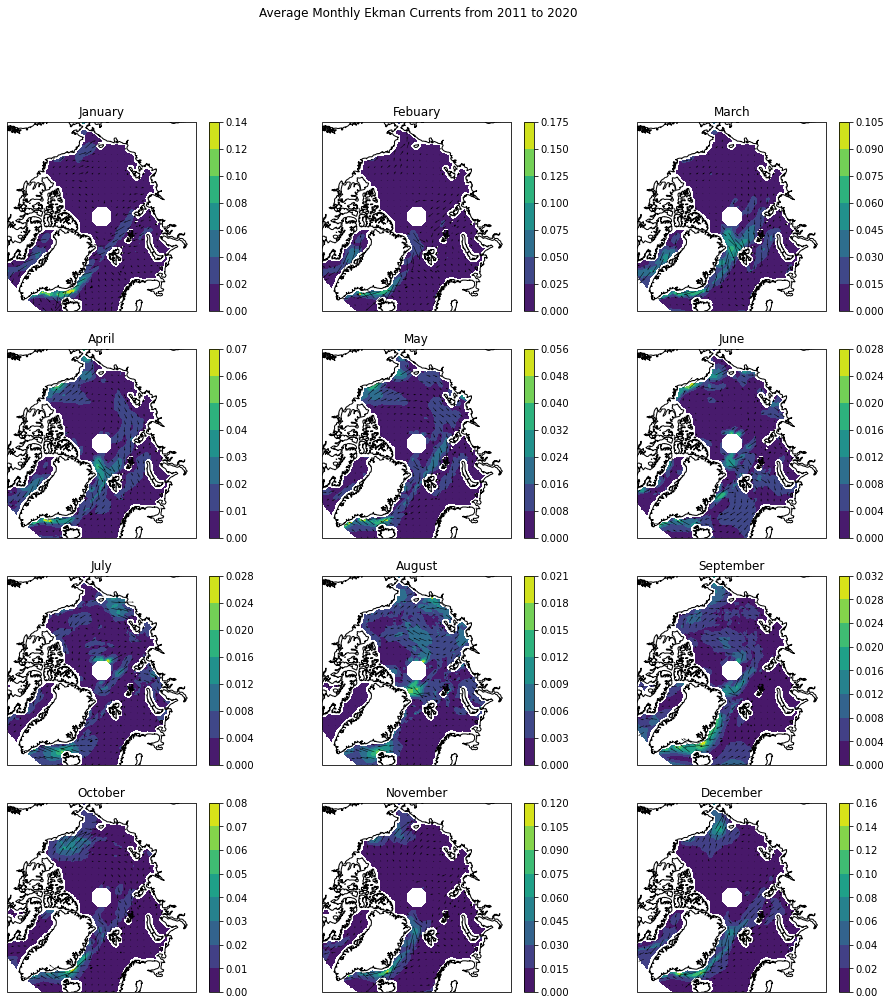

In [62]:
f = plt.figure(figsize=(16, 16))
plt.suptitle('Average Monthly Ekman Currents from 2011 to 2020')

#jan
ax = plt.subplot(4,3,1,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_jan[:,:,0],ek_jan[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekvr_jan,ekur_jan) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('January')

#feb
ax = plt.subplot(4,3,2,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_feb[:,:,0],ek_feb[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_feb,ekvr_feb) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('Febuary')

#mar
ax = plt.subplot(4,3,3,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_mar[:,:,0],ek_mar[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_mar,ekvr_mar) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('March')

#april
ax = plt.subplot(4,3,4,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_apr[:,:,0],ek_apr[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_apr,ekvr_apr) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('April')

#may
ax = plt.subplot(4,3,5,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_may[:,:,0],ek_may[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_may,ekvr_may) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('May')

#jun
ax = plt.subplot(4,3,6,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_jun[:,:,0],ek_jun[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_jun,ekvr_jun) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('June')

#july
ax = plt.subplot(4,3,7,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_jul[:,:,0],ek_jul[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_jul,ekvr_jul) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('July')

#aug
ax = plt.subplot(4,3,8,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_aug[:,:,0],ek_aug[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_aug,ekvr_aug) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('August')

#sept
ax = plt.subplot(4,3,9,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_sep[:,:,0],ek_sep[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_sep,ekvr_sep) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('September')

#oct
ax = plt.subplot(4,3,10,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_oct[:,:,0],ek_oct[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_oct,ekvr_oct) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('October')

#nov
ax = plt.subplot(4,3,11,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_nov[:,:,0],ek_nov[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_nov,ekvr_nov) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('November')

#dec
ax = plt.subplot(4,3,12,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ek_dec[:,:,0],ek_dec[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,ekur_dec,ekvr_dec) ## scale = 0.1
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('December')

#f.savefig('Ek_currentsGOOD_2011-2020.pdf',dpu = 250)

#### EKMAN PUMPING

In [83]:
pump_min =-50.0
pump_max = 50.0

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63284/1635735712.py:100: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpu" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Ek_pumping2011-2020.pdf',dpu = 250)


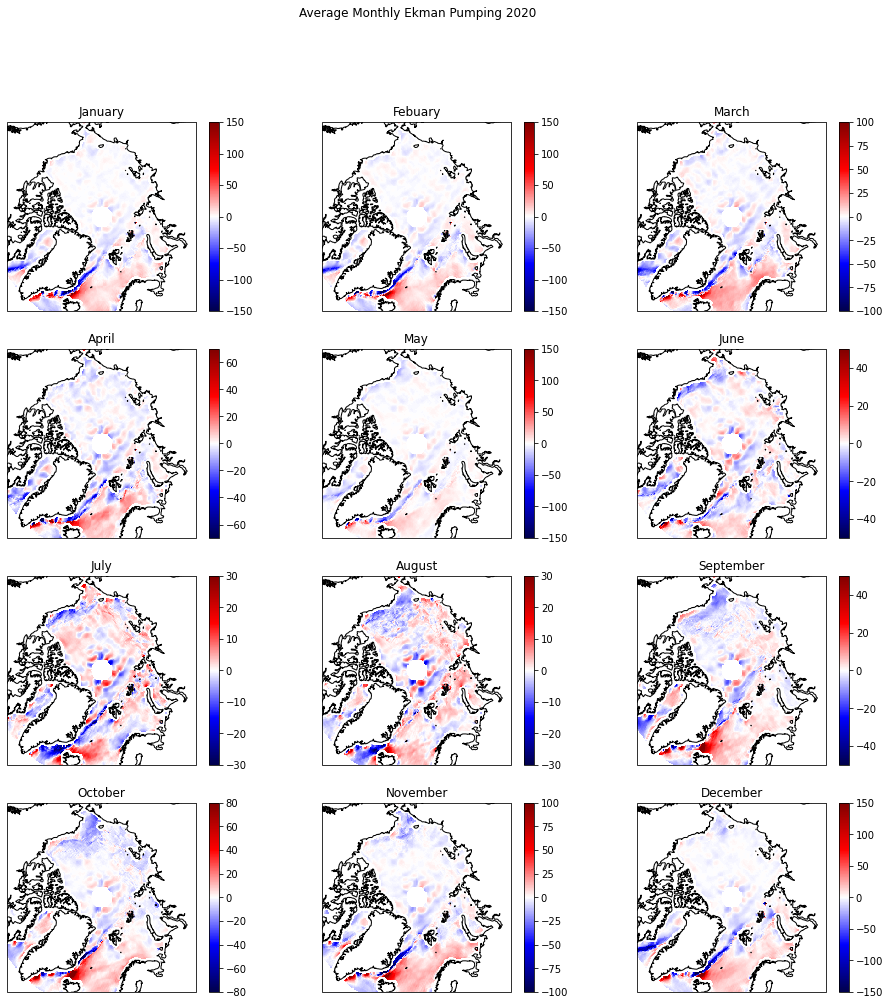

In [82]:
f = plt.figure(figsize=(16,16))
plt.suptitle('Average Monthly Ekman Pumping 2020')

ax = plt.subplot(4,3,1,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_jan,cmap='seismic',vmin=-150,vmax=150)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("January")

ax = plt.subplot(4,3,2,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_feb,cmap='seismic',vmin=-150,vmax=150)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("Febuary")

ax = plt.subplot(4,3,3,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_mar,cmap='seismic',vmin=-100,vmax=100)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("March")

ax = plt.subplot(4,3,4,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_apr,cmap='seismic',vmin=-70,vmax=70)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("April")

ax = plt.subplot(4,3,5,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_may,cmap='seismic',vmin=-150,vmax=150)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("May")

ax = plt.subplot(4,3,6,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_jun,cmap='seismic',vmin=-50,vmax=50)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("June")

ax = plt.subplot(4,3,7,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_jul,cmap='seismic',vmin=-30,vmax=30)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("July")

ax = plt.subplot(4,3,8,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_aug,cmap='seismic',vmin=-30,vmax=30)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("August")

ax = plt.subplot(4,3,9,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_sep,cmap='seismic',vmin=-50,vmax=50)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("September")

ax = plt.subplot(4,3,10,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_oct,cmap='seismic',vmin=-80,vmax=80)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("October")

ax = plt.subplot(4,3,11,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_nov,cmap='seismic',vmin=-100,vmax=100)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("November")

ax = plt.subplot(4,3,12,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec,cmap='seismic',vmin=-150,vmax=150)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("December")

#f.savefig('Ek_pumping2011-2020.pdf',dpu = 250)

/Users/owylie/opt/anaconda3/envs/MSCI/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Text(0.5, 1.0, 'Averaged')

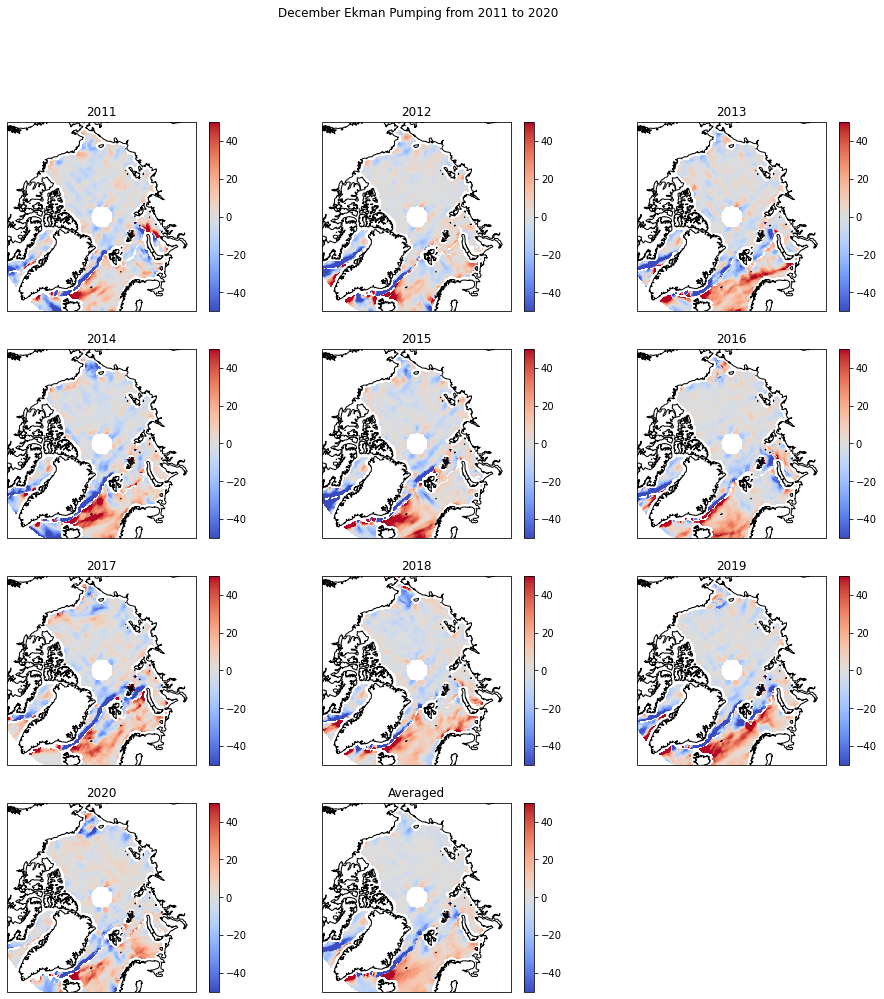

In [84]:
#December for every year
f = plt.figure(figsize=(16,16))
plt.suptitle('December Ekman Pumping from 2011 to 2020')

ax = plt.subplot(4,3,1,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec11,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2011")

ax = plt.subplot(4,3,2,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec12,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2012")

ax = plt.subplot(4,3,3,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec13,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2013")

ax = plt.subplot(4,3,4,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec14,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2014")

ax = plt.subplot(4,3,5,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec15,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2015")

ax = plt.subplot(4,3,6,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec16,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2016")

ax = plt.subplot(4,3,7,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec17,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2017")

ax = plt.subplot(4,3,8,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec18,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2018")

ax = plt.subplot(4,3,9,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec19,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2019")

ax = plt.subplot(4,3,10,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec20,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2020")

ax = plt.subplot(4,3,11,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,pump_dec,cmap='coolwarm',vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("Averaged")
#f.savefig('Ek_pumping_nov_2011-2020.pdf',dpu = 250)

Text(0.5, 1.0, '2019')

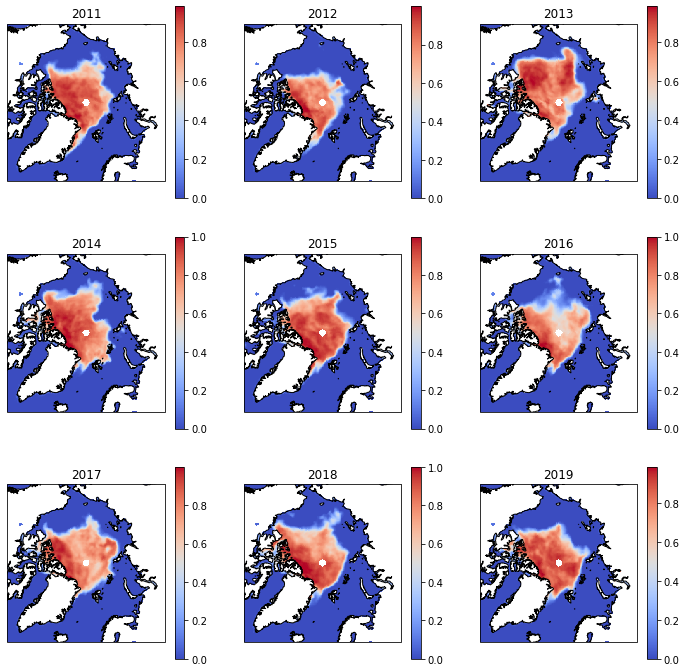

In [66]:
f = plt.figure(figsize=(12,12))
ax = plt.subplot(3,3,1,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep11r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2011")

ax = plt.subplot(3,3,2,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep12r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2012")

ax = plt.subplot(3,3,3,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep13r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2013")

ax = plt.subplot(3,3,4,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep14r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2014")

ax = plt.subplot(3,3,5,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep15r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2015")

ax = plt.subplot(3,3,6,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep16r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2016")

ax = plt.subplot(3,3,7,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep17r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2017")

ax = plt.subplot(3,3,8,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep18r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2018")

ax = plt.subplot(3,3,9,projection=m)
### next line is identical to plotting grid
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ic_sep19r,cmap='coolwarm')#,vmin=pump_min,vmax=pump_max)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("2019")